## **Explaining Monthly Average Stock Returns Around 5 Stock Market Crashes (1987-2022) 📉**
### Author: Robert Zhang
Colab Link: https://drive.google.com/file/d/1IW_RJy9SQg1g3G9iLnT3eugI05Iv89Ye/view?usp=sharing

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

### ➡️ **Introduction: Financial Analytics of Stock Market Crashes (1987~2022)**

#### 💡***Analytics Objective:*** Analyzing relationship between monthly average stock returns $(Ret_i)$, risk factors, financial ratios, and fixed industry effects around 5 market crashes. 

>**Project Overview:** Steps are presented below for analyzing **market crashes in 1987, 2000, 2008, 2020, and 2022.** We first filter the `CRSP` dataframe for specific stock return data (`crash_return`) during the distinct market crash periods, and then merge the resulting df with the corresponding `Compustat` data to calculate regression coefficients based on various fundamental ratios. We will then add risk exposures and industry-fixed effects to this analysis to complete our model. Industry effects are calculated on industry categorical variables based on `GSECTOR` code, which ranges from $[10, 60]$ varying from Energy to Real Estate. Interpretations of regression coefficients and results are discussed for each market period. 

> **Three components of this project are:**
- Regressing $Ret_{Stock}$ on 5 company-specific financial ratios: **ROA, ROE, Net Profit Margin, Asset Turnover ratio, and Long-Term Debt-to-Asset ratio.**
- Regressing $Ret_{Stock}$ on **Fama-French Factors**: Equity-Risk Premium $(R_M-R_f)$, Small-minus-Big $(SMB)$, High-minus-Low $(HML)$. 
- Regressing $Ret_{Stock}$ on **Industry-Fixed Effects**: Use `gsector_x` as industry-specific factor in interpreting stock returns. 
- **The combined regression is:**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}



---
### **1. 1987 Stock Market Crash (Sept 1987 – Dec 1987)**

In [156]:
Rt_1987 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/CRSP-1983-1987.csv')
display(Rt_1987.info())
# filter for event-specific returns
crash_data = Rt_1987[Rt_1987["date"] > '1987-08-31']
crash_return = pd.DataFrame(crash_data.groupby('TICKER')['RET'].mean()).reset_index()
display(crash_return)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377958 entries, 0 to 377957
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  377958 non-null  int64  
 1   date    377958 non-null  object 
 2   TICKER  377921 non-null  object 
 3   CUSIP   377958 non-null  object 
 4   RET     377958 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


None

,TICKER,RET
0,A,-0.152742
1,AA,-0.019691
2,AAA,0.011342
3,AAC,-0.056673
4,AAGIY,-0.035499
...,...,...
7328,ZRN,-0.080992
7329,ZRO,-0.040455
7330,ZSILF,-0.231214
7331,ZTCLF,-0.122449


- **`crash_data`**: Keeps only stock returns for Sept 1987 - Dec 1987 since this is the timeframe for the first crash event.

- **`crash_return`:** Calculates average monthly stock return for period between $09/1987-12/1987$ for each ticker. In this dataset, there are 7333 tickers and their respective returns in the crash period. 

- Combine `crash_return` with the corresponding `Compustat-1986.csv` file into a merged dataset for regression analysis. Since tickers in the Compustat dataset is not standardized, we need some data cleaning & transformation before merging on `tic`. 

In [157]:
Compustat_1986 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/Compustat-1986.csv')
# merge 2 df on ticker
merged_1987 = pd.merge(crash_return, Compustat_1986, left_on='TICKER', right_on='tic')
merged_1987 = merged_1987.drop(['gvkey', 'consol', 'popsrc', 'datafmt', 'tic', 'curcd', 'costat'], axis=1)
merged_1987['se'] = merged_1987['at'] - merged_1987['lt']
merged_1987['GP'] = merged_1987['sale'] - merged_1987['cogs']
display(merged_1987.tail())
display(merged_1987.info())

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se,GP
1663,ZMX,-0.064006,1986-12-31,1986,INDL,21.769,34.456,5.390,28.820,0.000,7.093,7.770,1.883,17.227,35.130,26.686,6.310
1664,ZNT,-0.092420,1986-12-31,1986,INDL,NaN,813.705,0.484,367.208,15.467,NaN,543.954,42.151,57.032,410.977,269.751,43.769
1665,ZOND,-0.122548,1986-12-31,1986,INDL,52.353,71.653,2.707,54.855,12.391,26.946,40.355,2.173,13.652,103.492,31.298,48.637
1666,ZRN,-0.080992,1987-03-31,1986,INDL,208.707,303.193,49.370,282.376,13.832,85.065,123.782,17.470,145.134,383.306,179.411,100.930
1667,ZRO,-0.040455,1987-03-31,1986,INDL,79.006,118.570,36.109,75.055,6.722,18.260,31.371,11.602,60.328,125.699,87.199,50.644


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 1667
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TICKER    1668 non-null   object 
 1   RET       1668 non-null   float64
 2   datadate  1668 non-null   object 
 3   fyear     1668 non-null   int64  
 4   indfmt    1668 non-null   object 
 5   act       1500 non-null   float64
 6   at        1668 non-null   float64
 7   che       1668 non-null   float64
 8   cogs      1667 non-null   float64
 9   dltt      1667 non-null   float64
 10  lct       1536 non-null   float64
 11  lt        1668 non-null   float64
 12  ni        1668 non-null   float64
 13  re        1651 non-null   float64
 14  sale      1668 non-null   float64
 15  se        1668 non-null   float64
 16  GP        1667 non-null   float64
dtypes: float64(13), int64(1), object(3)
memory usage: 234.6+ KB


None

- After merging on ticker symbol, we have 1668 companies left compared to the original 7333 companies in Compustat. Columns with null values are `act`, `cogs`, `dltt`, `lct`, and `re`. **Since financial data have relationships with one another, missing values can be predicted using other columns through regression.** We choose to use regression imputation of missing values instead of winsorizing or mean/median imputation since company-specific regression brings meanings meaning to numbers. Also, companies all have different scale and revenue size that bring challenges to winsorizing and simple imputation (i.e., distorting the big picture).

#### **Regression Imputation of Missing Variables**

In [158]:
from sklearn.linear_model import LinearRegression
#create copy of merged_1987 df for imputation of missing values
reg_data = merged_1987[['TICKER', 'datadate', 'act', 'cogs', 'dltt', 'lct', 're', 'che', 'lt', 'ni', 'sale']].copy()
reg_data = reg_data.dropna(subset=['che', 'lt', 'ni', 'sale']) #independent variables
#seperate missings from complete data
complete_data = reg_data.dropna() #drop null values in training set
missing_data = reg_data[reg_data.isna().any(axis=1)] #use rows with null for training set
#define variables
X_cols = ['che', 'lt', 'ni', 'sale']
y_cols = ['act', 'cogs', 'dltt', 'lct', 're']
#regression imputation of missing value NaN.
reg_model = LinearRegression()
reg_model.fit(complete_data[X_cols], complete_data[y_cols])
imputed_values = reg_model.predict(missing_data[X_cols])
merged_1987.loc[missing_data.index, y_cols] = imputed_values
display(merged_1987.describe())
display(merged_1987.tail())

,RET,fyear,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se,GP
count,1668.000000,1668.0,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1667.000000
mean,-0.071140,1986.0,535.593060,1520.799920,152.676499,622.779279,465.345784,388.015778,1086.762634,47.919781,326.985194,1031.917171,434.037287,293.402941
std,0.071579,0.0,2479.310846,6457.650254,1013.781688,4109.169186,2375.174831,1855.198775,5249.759525,250.235080,1561.692497,5031.671485,1919.094948,1306.584532
min,-0.435185,1986.0,0.000000,0.092000,-1.086000,-23479.278785,0.000000,-29.925425,0.000000,-2017.521000,-2642.146981,0.004000,-1025.196000,-57.440000
25%,-0.110276,1986.0,8.659000,15.618250,1.201750,4.753500,0.893750,2.777000,5.612000,0.053500,0.841000,14.507250,6.792750,4.745000
50%,-0.066137,1986.0,35.390381,65.072500,5.597000,33.698000,10.021500,14.549500,29.548000,2.312000,15.956723,72.622000,30.748000,22.317000
75%,-0.029709,1986.0,170.325750,411.876750,28.951250,201.095500,82.449997,86.566750,220.774750,16.984500,106.090500,381.611000,161.935750,113.636000
max,0.400000,1986.0,56982.411211,117086.000000,32041.707000,94530.625000,46970.571092,38026.184689,111411.608000,4789.000000,28141.008000,102813.000000,37712.000000,31860.012000


,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se,GP
1663,ZMX,-0.064006,1986-12-31,1986,INDL,21.769000,34.456,5.390,28.820000,0.000000,7.093000,7.770,1.883,17.227000,35.130,26.686,6.310
1664,ZNT,-0.092420,1986-12-31,1986,INDL,180.934722,813.705,0.484,176.478147,289.021484,121.579054,543.954,42.151,169.383486,410.977,269.751,43.769
1665,ZOND,-0.122548,1986-12-31,1986,INDL,52.353000,71.653,2.707,54.855000,12.391000,26.946000,40.355,2.173,13.652000,103.492,31.298,48.637
1666,ZRN,-0.080992,1987-03-31,1986,INDL,208.707000,303.193,49.370,282.376000,13.832000,85.065000,123.782,17.470,145.134000,383.306,179.411,100.930
1667,ZRO,-0.040455,1987-03-31,1986,INDL,79.006000,118.570,36.109,75.055000,6.722000,18.260000,31.371,11.602,60.328000,125.699,87.199,50.644


- **Observation:** Previously, before the regression imputation of `merged_1987` df, we saw that `act`, `cogs`, `dltt`, `lct`, `re` all have NaNs. Now, with company-specific regression imputation, they have 1668 complete observations. 
    - ***Rationality Check:*** For example, observation 1664 with ticker `ZNT` previously had no `act` and `lct` numbers. After regression imputation, it makes sense to see a smaller current assets compared to total assets (180 vs 813), and a smaller current liabilities compared to total liabilities (121 vs 543). 

#### **Combine with FF-3 Factors & GSECTOR Data:**

In [159]:
FF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/FF-Factors-1983-2022.csv')
industry_1987 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/GSECTOR-1986.csv')
industry_1987 = industry_1987.iloc[:, 2:]
# merge merged_1987 with FF on datadate
merged_1987 = pd.merge(merged_1987, FF, left_on="datadate", right_on='date')
# merge merged_1987 and industry_1987 on ticker
merged_1987 = pd.merge(merged_1987, industry_1987, left_on="TICKER", right_on="tic")
# create dummy variables for gsector 
merged_1987 = pd.get_dummies(merged_1987, columns=['gsector'])
merged_1987.loc[:, 'gsector_10.0':] = merged_1987.loc[:, 'gsector_10.0':].astype('float64')

In [160]:
final_1987 = merged_1987.drop(columns=["fyear", "indfmt", "date", "tic"])
display(final_1987.columns)

Index(['TICKER', 'RET', 'datadate', 'act', 'at', 'che', 'cogs', 'dltt', 'lct',
       'lt', 'ni', 're', 'sale', 'se', 'GP', 'mktrf', 'smb', 'hml', 'rf',
       'gsector_10.0', 'gsector_15.0', 'gsector_20.0', 'gsector_25.0',
       'gsector_30.0', 'gsector_35.0', 'gsector_40.0', 'gsector_45.0',
       'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

- `final_1987` now contains stock returns $Ret$ with respect to financials, risk exposures, and gsector information. Now we calculate ratios based on this data. 

#### **Create Financial Ratios: $log(Asset), ROA, ROE, Asset \ Turnover, Net \ Profit \ Margin, and \ LT \ Debt/Asset$**

In [161]:
# Size differential log(Assets)
final_1987['at'] = np.log(final_1987['at'])
# ROA
final_1987['ROA'] = np.log((final_1987['ni']+1)/(final_1987['at']+1))
# ROE
final_1987['ROE'] = np.log((final_1987['ni']+1)/(final_1987['se']+1))
# Asset turnover
final_1987['asset_turn'] = np.log((final_1987['sale']+1)/(final_1987['at']+1))
# Net profit margin
final_1987['net_margin'] = np.log((final_1987['ni']+1)/(final_1987['sale']+1))
# Long Tem Debt to Total Assets Ratio
final_1987['debt_asset'] = (final_1987['dltt']+1)/(final_1987['at']+1)
display(final_1987[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,1444.000000,1219.000000,1219.000000,1442.000000,1221.000000,1444.000000
mean,4.565262,0.434965,-1.838949,2.844705,-2.535504,50.906458
std,2.455721,1.613494,0.893745,1.829538,1.047171,213.948198
min,-2.385967,-6.409185,-8.071856,-1.476256,-9.981678,-2.169113
25%,2.786122,-0.627662,-2.173796,1.463136,-3.040278,0.670407
50%,4.249146,0.049923,-1.832958,2.703113,-2.499507,2.486909
75%,6.219694,1.357623,-1.396085,4.024187,-1.964383,14.040597
max,11.670664,5.992301,2.442606,9.043246,0.616326,3746.971505


- In calculating the above 5 ratios, 1 is added to the denominators to avoid infinitely large numbers due to the nature of $log(0)=-∞$. In particular, 1 is added to numerator and both denominator of all ratios.
- For all ratios, their maximum values are much higher than the 75th percentile results (same pattern is true for min and 25th percentile), so we need to winsorize these ratios on the 1th and 99th boundaries. We should only winsorize outlier ratios not outliers themselves. 
- **Reason for using the $log$ form of financial ratios:** Taking the logarithm of ratios reduces impact of outliers and make the monthly return regression results more robust. Thus, the interpretation of their coefficients should be a measure of elasticity → how a 1% in these ratios leads to changes in $Ret_i$. For example, $log(Asset)$ is included to account for the different size effect on stock returns. 
- **Only LT debt-to-asset ratio doesn't take the log form, this is because its value should always be greater than 0 (debt cannot fall below 0 and asset cannot be negative)**. If we take the log form of debt-to-asset ratio in 1987 crash, even its maximum value falls within the negative range, which is uninterpretable. 

In [162]:
# Winsorize financial ratios
from scipy.stats.mstats import winsorize
final_1987['at'] = winsorize(final_1987['at'], limits=(0.01,0.01))
final_1987['ROA'] = winsorize(final_1987['ROA'], limits=(0.01,0.01))
final_1987['ROE'] = winsorize(final_1987['ROE'], limits=(0.01,0.01))
final_1987['asset_turn'] = winsorize(final_1987['asset_turn'], limits=(0.01,0.01))
final_1987['net_margin'] = winsorize(final_1987['net_margin'], limits=(0.01,0.01))
final_1987['debt_asset'] = winsorize(final_1987['debt_asset'], limits=(0.01,0.01))
display(final_1987.iloc[:, 30:].describe())

,ROA,ROE,asset_turn,net_margin,debt_asset
count,1219.000000,1219.000000,1444.000000,1221.000000,1444.000000
mean,0.447600,-1.826760,2.846210,-2.522805,42.386140
std,1.579632,0.842819,1.812806,0.995981,125.009561
min,-2.957379,-4.563308,-0.686663,-5.502774,0.155179
25%,-0.627662,-2.173796,1.463600,-3.040278,0.670407
50%,0.049923,-1.832958,2.704979,-2.499507,2.486909
75%,1.357623,-1.396085,4.042715,-1.964383,14.040597
max,5.992301,2.442606,7.368204,0.616326,806.913826


- **Pre and post-winsorization comparison:** Extreme values, especially in ROE and debt-to-asset ratio, are trimmed to the 99th percentile instead of being deleted, and the numbers are more reasonable when compared to the 75th percentile results. In the 1987 crash, ROA as a proxy for profitability exhibited the highest volatility with pplenty of negative values, indicating that many firms were generating negative net income (losing money) given the assets they possessed. 

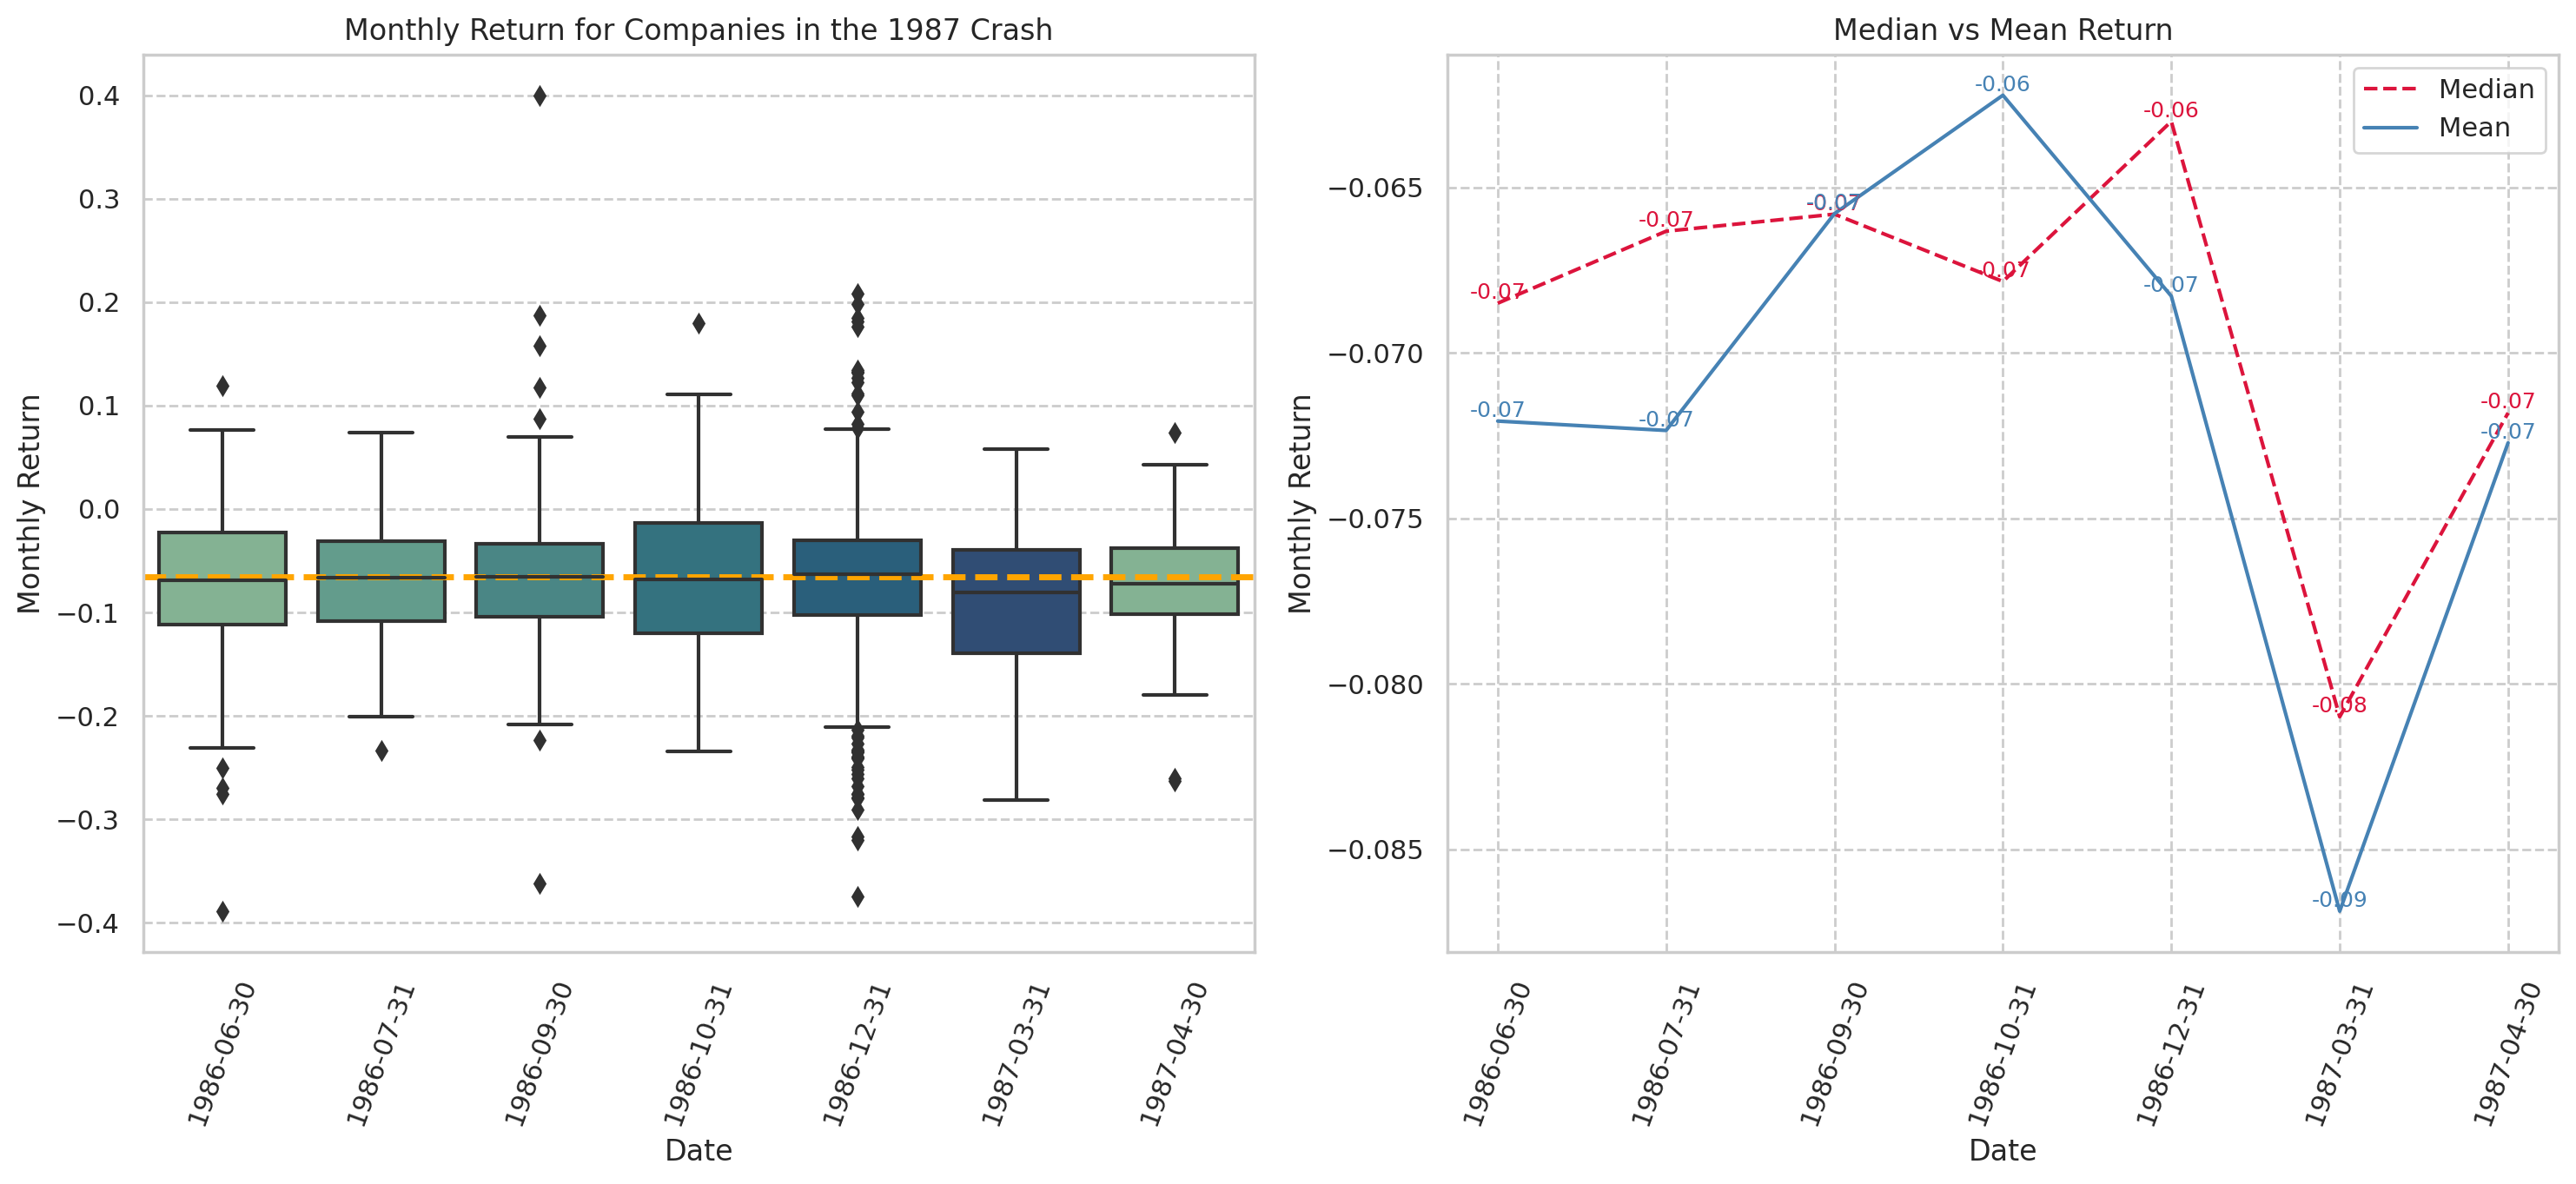

In [163]:
# Analyzing stock returns over the crash period
palette = sns.color_palette('crest')
# Sort the dataframe by datadate
final_1987 = final_1987.sort_values('datadate')
median_return = final_1987['RET'].median()
mean_return = final_1987['RET'].mean()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# Boxplot on avg RET distribution
sns.boxplot(x='datadate', y='RET', data=final_1987, palette=palette, ax=ax1)
ax1.axhline(y=median_return, color='orange', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Return')
ax1.set_xticklabels(labels=final_1987['datadate'].unique(), rotation=70)
ax1.set_title('Monthly Return for Companies in the 1987 Crash')
# Line plot on avg vs median RET comparison
x = final_1987['datadate'].unique()
y_median = final_1987.groupby('datadate')['RET'].median().values
y_mean = final_1987.groupby('datadate')['RET'].mean().values
ax2.plot(x, y_median, color='crimson', linestyle='--', label='Median')
ax2.plot(x, y_mean, color='steelblue', linestyle='-', label='Mean')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_xticklabels(labels=x, rotation=70)
ax2.set_title('Median vs Mean Return')
ax2.legend()
# Add data labels on the line plot
for i, (xi, yi) in enumerate(zip(x, y_median)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='crimson')
for i, (xi, yi) in enumerate(zip(x, y_mean)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='steelblue')
fig.tight_layout()
plt.show()

- Monthly average returns from $1986/06/30 - 1987/04/30$ uniformly fell below 0%, with only a few outliers each month reaching above 0%. 12/1986 has the most stock return volatility on both side of the spectrum as investors dump losers and re-buy new positions in January. The orange dotted line depicts the median stock return over the entire crash period, which is also below 0%.
- Market experienced significant sell-off from 12/1986-03/1987, with median $R_i$ dropping from -6% to -9%. 

#### **Regressing Returns $(R_{Stock})$ on Financial Ratios**
- Here, we regress individual stock's monthly average returns on the 6 ratios calculated above, and interpret meanings of coefficients. 
> **Regression 1 is based on financial characteristics, Regression 2 is based on industry fixed effects, and Regression 3 is a combination of risk exposures, ratios, and industry effects.** *Regression only based on Fama-French factors is omitted since none of the variables have significant results. They will however be analyzed in the combined regression.* **We compare overall $R^2$ and $Adj. R^2$ results.**

In [164]:
# Regression 1 - Ratio Analysis
import statsmodels.api as sm
ratio = final_1987[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
X = ratio.fillna(0)
X = sm.add_constant(X)
y = final_1987['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     6.463
Date:                Sat, 06 May 2023   Prob (F-statistic):           9.73e-07
Time:                        03:30:09   Log-Likelihood:                 1817.7
No. Observations:                1444   AIC:                            -3621.
Df Residuals:                    1437   BIC:                            -3584.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0783      0.005    -14.697      0.000      -0.089      -0.068
at            -0.0027      0.002     -1.345      0.179      -0.007       0.001
ROA            0.0071      0.002      3.077      0.002       0.003       0.012
ROE           -0.0107      0.003     -3.211      0.001      -0.017      -0.004
asset_turn     0.0027      0.003      0.927      0.354      -0.003       0.008
net_margin     0.0023      0.003      0.812      0.417      -0.003       0.008
debt_asset -2.006e-05   1.86e-05     -1.076      0.282   -5.66e-05    1.65e-05
==============================================================================
Omnibus:                      127.863   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              730.195
Skew:                           0.152   Prob(JB):                    2.76e-159
Kurtosis:                       6.470   Cond. No.                         412.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
# Regression 2 - Industry-Fixed Effect
import statsmodels.api as sm
sector = final_1987.iloc[:, 20:30] #drop gsector_10 as the base comparison
X = sector.fillna(0)
X = sm.add_constant(X)
y = final_1987['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.760
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.19e-05
Time:                        03:30:09   Log-Likelihood:                 1817.1
No. Observations:                1444   AIC:                            -3612.
Df Residuals:                    1433   BIC:                            -3554.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0883      0.008    -10.929      0.000      -0.104      -0.072
gsector_15.0     0.0434      0.011      4.062      0.000       0.022       0.064
gsector_20.0     0.0145      0.009      1.618      0.106      -0.003       0.032
gsector_25.0     0.0159      0.009      1.730      0.084      -0.002       0.034
gsector_30.0     0.0255      0.011      2.299      0.022       0.004       0.047
gsector_35.0     0.0074      0.010      0.743      0.457      -0.012       0.027
gsector_40.0     0.0158      0.010      1.592      0.112      -0.004       0.035
gsector_45.0     0.0172      0.009      1.852      0.064      -0.001       0.035
gsector_50.0     0.0165      0.015      1.087      0.277      -0.013       0.046
gsector_55.0     0.0456      0.011      4.054      0.000       0.024       0.068
gsector_60.0     0.0385      0.018      2.165      0.031       0.004       0.073
==============================================================================
Omnibus:                      119.202   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              684.004
Skew:                          -0.010   Prob(JB):                    2.95e-149
Kurtosis:                       6.372   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
import statsmodels.api as sm

sector = final_1987.iloc[:, 20:30] #drop gsector_10 as the base comparison
ratio = final_1987[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
risk = final_1987[['smb', 'hml', 'mktrf']]

X = pd.concat([sector, ratio, risk], axis=1).fillna(0)
X = sm.add_constant(X)
y = final_1987['RET']

model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.495
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.50e-07
Time:                        03:30:09   Log-Likelihood:                 1831.3
No. Observations:                1444   AIC:                            -3623.
Df Residuals:                    1424   BIC:                            -3517.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0906      0.010     -9.336      0.000      -0.110      -0.072
gsector_15.0     0.0355      0.011      3.277      0.001       0.014       0.057
gsector_20.0     0.0094      0.009      1.018      0.309      -0.009       0.028
gsector_25.0     0.0124      0.009      1.313      0.190      -0.006       0.031
gsector_30.0     0.0178      0.012      1.540      0.124      -0.005       0.041
gsector_35.0     0.0033      0.010      0.328      0.743      -0.016       0.023
gsector_40.0     0.0128      0.010      1.228      0.220      -0.008       0.033
gsector_45.0     0.0147      0.009      1.556      0.120      -0.004       0.033
gsector_50.0     0.0076      0.015      0.499      0.618      -0.022       0.037
gsector_55.0     0.0348      0.011      3.051      0.002       0.012       0.057
gsector_60.0     0.0328      0.018      1.839      0.066      -0.002       0.068
at              -0.0033      0.002     -1.489      0.137      -0.008       0.001
ROA              0.0062      0.002      2.629      0.009       0.002       0.011
ROE             -0.0094      0.003     -2.761      0.006      -0.016      -0.003
asset_turn       0.0030      0.003      0.973      0.331      -0.003       0.009
net_margin       0.0020      0.003      0.666      0.505      -0.004       0.008
debt_asset   -1.417e-05   1.95e-05     -0.727      0.467   -5.24e-05    2.41e-05
smb             -0.0820      0.192     -0.428      0.668      -0.458       0.294
hml             -0.1133      0.184     -0.617      0.537      -0.473       0.247
mktrf           -0.0856      0.086     -1.001      0.317      -0.253       0.082
==============================================================================
Omnibus:                      129.208   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.829
Skew:                           0.134   Prob(JB):                    2.26e-166
Kurtosis:                       6.551   Cond. No.                     1.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression Comparison Results**: Regressing on characteristics alone has an $Adj R^2$ of 2.2%, and industry effects have an $Adj R^2$ of 1.9%. Regression based on industry generated improvement on the first model with higher adjusted R-squared. Significant variables in both models are `ROA`, `ROE`, `gsector_10`, and `gsector_15`, `gsector_30`, `gsector_55`, `gsector_60` respectively. Regression 3 has an $Adj R^2$ of 3.2%.

**Combined Model Interpretation (Industry + Risk Exposure + Ratios):**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}

- The combined regression model based on industry-fixed effect ($𝛼_i$), financial characteristics ($𝛾_{1-6}$), and risk exposures ($β_{1-3}$) is displayed above. Due to the abundance of gsector variables, they are simplified in the regression as $gsector_{15-60}$, with $gsector_{10}$ embedded in the constant. $R^2 = 0.045$ meaning that ~4.5% of the variations in monthly $RET_t$ can be explained by the combination of variables presented above. 
1. **Intercept**: On average, during the 1987 crash period, companies in the **gsector10 industry (Energy)** generated a monthly return of -9.06%, assuming all other variables = 0. We have 1444 observations in total, each representing a ticker symbol in the `final_1987` dataset. 
1. **Coefficients**: Statistically significant variables include `gsector_15`, `gsector_55`, `ROA`, and `ROE`. **This means these 2 industries in Materials and Utilities have significant return differences compared to the baseline Energy industry**, and their positive coefficients suggest that they generated higher average returns than Energy, holding other things constant. Both **ROA and ROE** are significant, and they should be interpreted on the log basis: A 1% increase in ROA indicates a 0.0062 increase in $RET$, while a 1% increase in ROE indicates a 0.0094 drop in $RET$. All risk exposure factors are insignificant in the 1987 crash period. 



---

### **2. 2000 Dot Com Bubble and Crash (Jan 2000 – Oct 2002)**

In [167]:
Rt_2000 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/CRSP-1997-2001.csv')
crash_data = Rt_2000[(Rt_2000["date"] > '2000-08-31') & (Rt_2000["date"] <= '2001-03-31')]
crash_return = pd.DataFrame(crash_data.groupby('TICKER')['RET'].mean()).reset_index()
display(crash_return.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  8583 non-null   object 
 1   RET     8583 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.2+ KB


None

- **`crash_data`**: Keeps only stock returns for Sept 2000 - Mar 2001 since this is the timeframe for the second crash event.

- **`crash_return`:** Calculates average monthly stock return for period between $09/2000-03/2001$ for each ticker. In this dataset, there are 8583 tickers and their respective returns in the crash period. 


In [168]:
Compustat_2000 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/Compustat-2000.csv')
# merge 2 df on ticker
merged_2000 = pd.merge(crash_return, Compustat_2000, left_on='TICKER', right_on='tic')
merged_2000 = merged_2000.drop(['gvkey', 'consol', 'popsrc', 'datafmt', 'tic', 'curcd', 'costat'], axis=1)
merged_2000['se'] = merged_2000['at'] - merged_2000['lt']
display(merged_2000.iloc[3:5]) #display rows with null values and compare later
display(merged_2000.info())

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
3,AAME,-0.007625,2000-12-31,2000,INDL,NaN,375.777,56.099,141.350,25.00,NaN,292.537,3.632,5.572,152.258,83.240
4,AANB,0.023203,2000-12-31,2000,INDL,NaN,160.651,15.077,4.603,0.81,NaN,143.678,2.460,4.101,14.355,16.973


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685 entries, 0 to 3684
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TICKER    3685 non-null   object 
 1   RET       3685 non-null   float64
 2   datadate  3685 non-null   object 
 3   fyear     3685 non-null   int64  
 4   indfmt    3685 non-null   object 
 5   act       2859 non-null   float64
 6   at        3685 non-null   float64
 7   che       3685 non-null   float64
 8   cogs      3685 non-null   float64
 9   dltt      3678 non-null   float64
 10  lct       2880 non-null   float64
 11  lt        3678 non-null   float64
 12  ni        3685 non-null   float64
 13  re        3639 non-null   float64
 14  sale      3685 non-null   float64
 15  se        3678 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 489.4+ KB


None

- After merging on ticker symbol, we have 3685 companies left compared to the original 8583 companies in `crash_return`. Columns with null values are `act`, `dltt`, `lct`, `lt`, `se`, and `re`. **Regression and data cleaning follow the same steps as before.**

#### **Regression Imputation**

In [169]:
#create copy of merged_2000 df for imputation of missing values
reg_data = merged_2000[['TICKER', 'datadate', 'act', 'cogs', 'dltt', 'lct', 're', 'che', 'lt', 'ni', 'sale', 'se']].copy()
reg_data = reg_data.dropna(subset=['cogs', 'che', 'ni', 'sale']) #independent variables
#seperate missings from complete data
complete_data = reg_data.dropna() #drop null values in training set
missing_data = reg_data[reg_data.isna().any(axis=1)] #use rows with null for training set
#define variables
X_cols = ['cogs', 'che', 'ni', 'sale']
y_cols = ['act', 'dltt', 'lct', 'lt', 'se', 're']
#regression imputation of missing value NaN.
reg_model = LinearRegression()
reg_model.fit(complete_data[X_cols], complete_data[y_cols])
imputed_values = reg_model.predict(missing_data[X_cols])
merged_2000.loc[missing_data.index, y_cols] = imputed_values
display(merged_2000.iloc[3:5]) #post imputation comparison vs before

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
3,AAME,-0.007625,2000-12-31,2000,INDL,153.666292,375.777,56.099,141.350,178.735014,61.414143,299.187059,3.632,-235.264176,152.258,-18.368820
4,AANB,0.023203,2000-12-31,2000,INDL,82.496328,160.651,15.077,4.603,161.531950,21.426481,224.675898,2.460,-296.837560,14.355,-132.861483


- **Observation:** Previously, before the regression imputation of `merged_2000` df, we saw that `act`, `dltt`, `lct`, `lt`, `se`, `re` all have NaNs. Now, with company-specific regression imputation, they have 3685 complete observations. 
    - ***Rationality Check:*** For example, tickers `AAME`, and `AANB` all have missing values in `act` and `lct`. After regression imputation, it makes sense to see a smaller current assets compared to total assets, and a smaller current liabilities compared to total liabilities. 

#### **Combine with FF-3 Factors & GSECTOR Data:**

In [170]:
FF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/FF-Factors-1983-2022.csv')
industry_2000 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/GSECTOR-2000.csv')
industry_2000 = industry_2000.iloc[:, 2:]
# merge merged_2000 with FF on datadate
merged_2000 = pd.merge(merged_2000, FF, left_on="datadate", right_on='date')
# merge merged_2000 and industry_2000 on ticker
merged_2000 = pd.merge(merged_2000, industry_2000, left_on="TICKER", right_on="tic")
# create dummy variables for gsector 
merged_2000 = pd.get_dummies(merged_2000, columns=['gsector'])
merged_2000.loc[:, 'gsector_10.0':] = merged_2000.loc[:, 'gsector_10.0':].astype('float64')

In [171]:
final_2000 = merged_2000.drop(columns=["fyear", "indfmt", "date", "tic"])
display(final_2000.columns)

Index(['TICKER', 'RET', 'datadate', 'act', 'at', 'che', 'cogs', 'dltt', 'lct',
       'lt', 'ni', 're', 'sale', 'se', 'mktrf', 'smb', 'hml', 'rf',
       'gsector_10.0', 'gsector_15.0', 'gsector_20.0', 'gsector_25.0',
       'gsector_30.0', 'gsector_35.0', 'gsector_40.0', 'gsector_45.0',
       'gsector_50.0', 'gsector_55.0', 'gsector_60.0'],
      dtype='object')

- `final_2000` now contains stock returns $Ret$ with respect to financials, risk exposures, and gsector information. Now we calculate ratios based on this data. 

#### **Create Financial Ratios: $log(Asset), ROA, ROE, Asset \ Turnover, Net \ Profit \ Margin, and \ LT \ Debt/Asset$**

In [172]:
# Size differential log(Assets)
final_2000['at'] = np.log(final_2000['at'])
# ROA
final_2000['ROA'] = np.log((final_2000['ni']+1)/(final_2000['at']+1))
# ROE
final_2000['ROE'] = np.log((final_2000['ni']+1)/(final_2000['se']+1))
# Asset turnover
final_2000['asset_turn'] = np.log((final_2000['sale']+1)/(final_2000['at']+1))
# Net profit margin
final_2000['net_margin'] = np.log((final_2000['ni']+1)/(final_2000['sale']+1))
# Long Tem Debt to Total Assets Ratio
final_2000['debt_asset'] = np.log((final_2000['dltt']+1)/(final_2000['at']+1))
display(final_2000[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,718.000000,534.000000,492.000000,715.000000,537.000000,715.000000
mean,5.294587,0.948612,-1.986439,3.335597,-2.720807,1.006850
std,1.984536,1.716161,0.972108,1.864043,1.013195,2.327441
min,-3.352407,-4.630030,-6.762754,-1.638505,-7.065168,-2.473330
25%,3.930634,-0.371788,-2.440867,1.987869,-3.382883,-1.248083
50%,5.237098,0.737630,-1.898673,3.184645,-2.720756,0.738475
75%,6.512142,1.931101,-1.513684,4.562201,-2.061750,3.158746
max,12.964057,6.677473,2.527381,9.658430,2.445076,7.336769


- In calculating the above 5 ratios, 1 is added to the denominators to avoid infinitely large numbers due to the nature of $log(0)=-∞$. In particular, 1 is added to numerator and both denominator of all ratios. 
- Compared to the original 3685 company observations, after merging with FF-3 Factor data and GSECTOR info we only have 718 observations remaining. 
- For all ratios, their maximum values are much higher than the 75th percentile results (same pattern is true for min and 25th percentile), so we need to winsorize these ratios on the 1th and 99th boundaries (especially true for debt-to-asset). We should only winsorize outlier ratios not outliers themselves. 
- **Reason for using the $log$ form of financial ratios:** Taking the logarithm of ratios reduces impact of outliers and make the monthly return regression results more robust. Thus, the interpretation of their coefficients should be a measure of elasticity → how a 1% in these ratios leads to changes in $Ret_i$. For example, $log(Asset)$ is included to account for the different size effect on stock returns. 

In [173]:
# Winsorize financial ratios
from scipy.stats.mstats import winsorize
final_2000['at'] = winsorize(final_2000['at'], limits=(0.01,0.01))
final_2000['ROA'] = winsorize(final_2000['ROA'], limits=(0.01,0.01))
final_2000['ROE'] = winsorize(final_2000['ROE'], limits=(0.01,0.01))
final_2000['asset_turn'] = winsorize(final_2000['asset_turn'], limits=(0.01,0.01))
final_2000['net_margin'] = winsorize(final_2000['net_margin'], limits=(0.01,0.01))
final_2000['debt_asset'] = winsorize(final_2000['debt_asset'], limits=(0.01,0.01))
display(final_2000.iloc[:, 30:].describe())

,ROE,asset_turn,net_margin,debt_asset
count,492.000000,718.000000,537.000000,718.000000
mean,-1.973926,3.355984,-2.714539,1.029515
std,0.930382,1.870184,0.992727,2.343526
min,-4.325437,-0.599388,-5.489701,-2.133648
25%,-2.440867,1.990429,-3.382883,-1.236157
50%,-1.898673,3.201837,-2.720756,0.773303
75%,-1.513684,4.571635,-2.061750,3.168440
max,2.527381,8.129364,2.445076,6.632885


- **Pre and post-winsorization comparison:** Extreme values, especially in ROE and debt-to-asset ratio, are trimmed to the 99th percentile instead of being deleted, and the numbers are more reasonable when compared to the 75th percentile results. In the 2000 Dotcom bubble, debt-to-asset ratio exhibited tremendous volatility and variation across companies, indicating that there are more variance in long-term debt levels given similar amount of assets. Asset turnover ratio also has great volatility and variance with a maximum value of 812.9% after winsorization. 

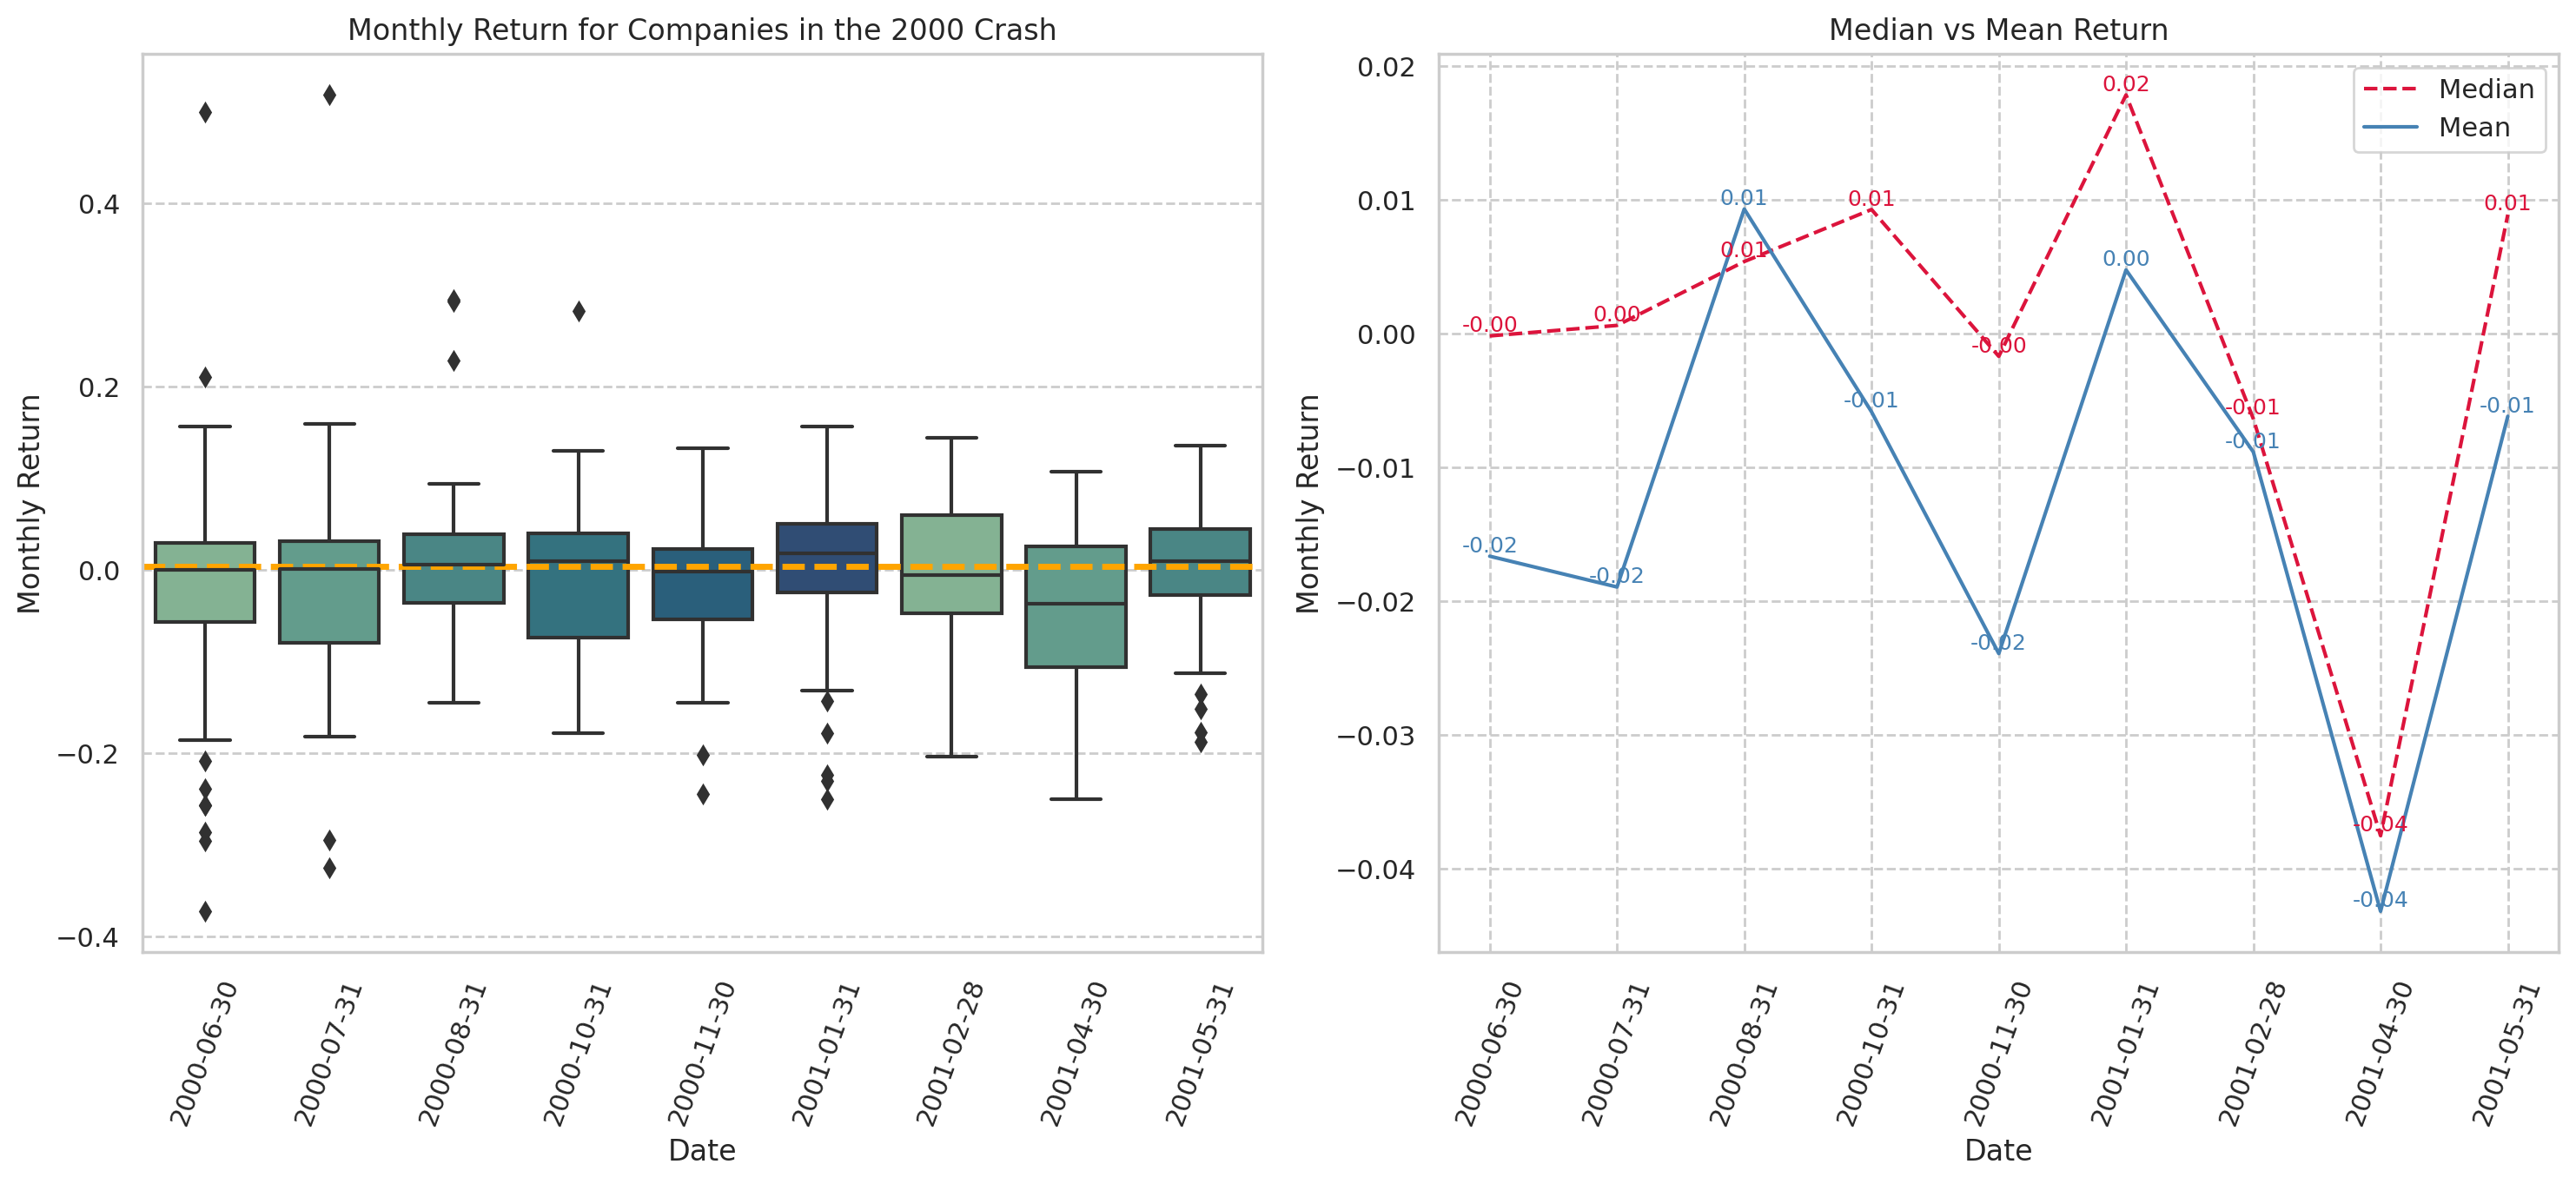

In [174]:
# Analyzing stock returns over the crash period
palette = sns.color_palette('crest')
# Sort the dataframe by datadate
final_2000 = final_2000.sort_values('datadate')
median_return = final_2000['RET'].median()
mean_return = final_2000['RET'].mean()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# Boxplot on avg RET distribution
sns.boxplot(x='datadate', y='RET', data=final_2000, palette=palette, ax=ax1)
ax1.axhline(y=median_return, color='orange', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Return')
ax1.set_xticklabels(labels=final_2000['datadate'].unique(), rotation=70)
ax1.set_title('Monthly Return for Companies in the 2000 Crash')
# Line plot on avg vs median RET comparison
x = final_2000['datadate'].unique()
y_median = final_2000.groupby('datadate')['RET'].median().values
y_mean = final_2000.groupby('datadate')['RET'].mean().values
ax2.plot(x, y_median, color='crimson', linestyle='--', label='Median')
ax2.plot(x, y_mean, color='steelblue', linestyle='-', label='Mean')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_xticklabels(labels=x, rotation=70)
ax2.set_title('Median vs Mean Return')
ax2.legend()
# Add data labels on the line plot
for i, (xi, yi) in enumerate(zip(x, y_median)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='crimson')
for i, (xi, yi) in enumerate(zip(x, y_mean)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='steelblue')
fig.tight_layout()
plt.show()

- During the 2000 crash period from $06/2000 - 06/2001$, median stock return over this period centered around 0%. More return volatilities appeared around 06/2000-10/2000, and median stock return dropped significantly from 2% to -4% from 01/2001 - 04/2001. 

#### **Regression $(RET_t)$ Analysis on Various Features**
- Here, we regress individual stock's monthly average returns on the 6 ratios calculated above, and interpret meanings of coefficients. 
> **Regression 1 is based on financial characteristics, Regression 2 is based on industry fixed effects, and Regression 3 is a combination of risk exposures, ratios, and industry effects.** *Regression only based on Fama-French factors is omitted since none of the variables have significant results. They will however be analyzed in the combined regression.* **We compare overall $R^2$ and $Adj. R^2$ results.**

In [175]:
# Regression 1 - Ratio Analysis
import statsmodels.api as sm
ratio = final_2000[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
X = ratio.fillna(0)
X = sm.add_constant(X)
y = final_2000['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     14.88
Date:                Sat, 06 May 2023   Prob (F-statistic):           4.59e-16
Time:                        03:30:12   Log-Likelihood:                 787.83
No. Observations:                 718   AIC:                            -1562.
Df Residuals:                     711   BIC:                            -1530.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0164      0.013     -1.251      0.211      -0.042       0.009
at            -0.0079      0.003     -2.629      0.009      -0.014      -0.002
ROA            0.0008      0.004      0.230      0.819      -0.006       0.008
ROE            0.0074      0.004      1.779      0.076      -0.001       0.016
asset_turn     0.0043      0.003      1.354      0.176      -0.002       0.010
net_margin    -0.0164      0.004     -4.470      0.000      -0.024      -0.009
debt_asset     0.0081      0.002      4.803      0.000       0.005       0.011
==============================================================================
Omnibus:                      101.955   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.401
Skew:                           0.367   Prob(JB):                    4.61e-166
Kurtosis:                       7.991   Cond. No.                         33.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
# Regression 2 - Industry-Fixed Effect
import statsmodels.api as sm
sector = final_2000.iloc[:, 19:29] #drop gsector_10 as the base comparison
X = sector.fillna(0)
X = sm.add_constant(X)
y = final_2000['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     13.01
Date:                Sat, 06 May 2023   Prob (F-statistic):           4.91e-21
Time:                        03:30:12   Log-Likelihood:                 806.00
No. Observations:                 718   AIC:                            -1590.
Df Residuals:                     707   BIC:                            -1540.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0419      0.026      1.585      0.113      -0.010       0.094
gsector_15.0    -0.0443      0.031     -1.443      0.149      -0.105       0.016
gsector_20.0    -0.0427      0.028     -1.551      0.121      -0.097       0.011
gsector_25.0    -0.0364      0.027     -1.339      0.181      -0.090       0.017
gsector_30.0    -0.0061      0.028     -0.214      0.831      -0.062       0.050
gsector_35.0    -0.0485      0.028     -1.740      0.082      -0.103       0.006
gsector_40.0    -0.0310      0.028     -1.099      0.272      -0.086       0.024
gsector_45.0    -0.1071      0.027     -3.953      0.000      -0.160      -0.054
gsector_50.0    -0.0568      0.037     -1.517      0.130      -0.130       0.017
gsector_55.0     0.0382      0.048      0.801      0.423      -0.055       0.132
gsector_60.0    -0.0340      0.040     -0.850      0.396      -0.113       0.045
==============================================================================
Omnibus:                      120.939   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1330.150
Skew:                           0.356   Prob(JB):                    1.45e-289
Kurtosis:                       9.630   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
# Regression 3 - Combined Regression
import statsmodels.api as sm

sector = final_2000.iloc[:, 19:29] #drop gsector_10 as the base comparison
ratio = final_2000[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
risk = final_2000[['smb', 'hml', 'mktrf']]

X = pd.concat([sector, ratio, risk], axis=1).fillna(0)
X = sm.add_constant(X)
y = final_2000['RET']

model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     9.634
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.39e-25
Time:                        03:30:12   Log-Likelihood:                 828.98
No. Observations:                 718   AIC:                            -1618.
Df Residuals:                     698   BIC:                            -1526.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0361      0.029      1.225      0.221      -0.022       0.094
gsector_15.0    -0.0634      0.030     -2.099      0.036      -0.123      -0.004
gsector_20.0    -0.0577      0.027     -2.134      0.033      -0.111      -0.005
gsector_25.0    -0.0529      0.027     -1.974      0.049      -0.106      -0.000
gsector_30.0    -0.0290      0.028     -1.033      0.302      -0.084       0.026
gsector_35.0    -0.0429      0.027     -1.576      0.115      -0.096       0.011
gsector_40.0    -0.0266      0.028     -0.940      0.348      -0.082       0.029
gsector_45.0    -0.1053      0.027     -3.945      0.000      -0.158      -0.053
gsector_50.0    -0.0661      0.037     -1.800      0.072      -0.138       0.006
gsector_55.0     0.0444      0.047      0.954      0.340      -0.047       0.136
gsector_60.0    -0.0283      0.040     -0.714      0.475      -0.106       0.049
at              -0.0071      0.003     -2.238      0.026      -0.013      -0.001
ROA             -0.0015      0.003     -0.433      0.665      -0.008       0.005
ROE              0.0025      0.004      0.591      0.555      -0.006       0.011
asset_turn       0.0102      0.004      2.786      0.005       0.003       0.017
net_margin      -0.0094      0.004     -2.540      0.011      -0.017      -0.002
debt_asset       0.0033      0.002      1.815      0.070      -0.000       0.007
smb             -0.0422      0.157     -0.268      0.788      -0.350       0.266
hml             -0.0125      0.246     -0.051      0.959      -0.496       0.471
mktrf            0.0294      0.212      0.139      0.890      -0.386       0.445
==============================================================================
Omnibus:                      121.167   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.652
Skew:                           0.435   Prob(JB):                    1.66e-244
Kurtosis:                       9.064   Cond. No.                         913.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression Comparison Results**: Regressing on characteristics alone has an $Adj R^2$ of 10.4%, and industry effects have an $Adj R^2$ of 14.3%. Regression based on industry generated improvement on the first model with higher adjusted R-squared. Significant variables in both models are `at`, `net_margin`, `debt_asset`, and `gsector_10` respectively. 

**Regression #3 Interpretation (Industry + Risk Exposure + Ratios):**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}

1. **The 2000 Dotcom bubble presented interesting regression results.** In particular, it has a much higher $R^2 = 0.208$ meaning that ~20.8% of the variations in monthly $RET_t$ can be explained by the combination of variables presented above. 
1. **Intercept**: On average, during the 2000 dotcom period, companies in the **gsector10 industry (Energy)** generated a monthly return of -3.61%, assuming all other variables = 0. We have 718 observations in total, each representing a ticker symbol in the `final_2000` dataset. If the merged dataset provided more observations, maybe we can have more robust results and statistical power. 
1. **Industry Coefficients**: Statistically significant variables include `gsector_15`, `gsector_20`, `gsector_25`, `gsector_45`. Since the 2000 bubble is mainly driven by **Irrational Exuberance** in the Information Technology sector (represented by gsector_45) as investors and companied mindlessly poured capital into building infrastructure and landlines, we observed `gsector_45` has the lowest p-value and most negative coefficient of -0.1053. This means that compared to the baseline Energy industry, IT companies during 2000 generated almost 10.53% lower returns on average, holding everything else equal. Other statistically significant industries include Materials, Industrials, and Consumer Discretionary. 
1. **Financial Characteristics**: `at`, `asset_turn`, and `net_margin` are all significant. For firm size, which is measured by $log(Asset)$, we observe that each 1% increase in assets indicates a 0.71% drop in $RET$ in 2000. A 1% increase in Asset Turnover ratio indicates a 1.02% increase in $RET$, so firms that generate more sales given similar level of assets performed better in 2000 on average. A 1% increase in Net Profit Margin indicates a 0.94% drop in $RET$, which is contradictory to common sense. 
1. **Fama-French 3 Factors**: None of the risk exposure factors are statistically significant in the 2000 crash period. 
---

### **3. 2008 Great Recession & Financial Crisis (Jan 2008 – Feb 2009)**

In [178]:
Rt_2008 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/CRSP-2004-2008.csv')
crash_data = Rt_2008[(Rt_2008["date"] >= '2008-08-31') & (Rt_2008["date"] <= '2008-11-31')]
crash_return = pd.DataFrame(crash_data.groupby('TICKER')['RET'].mean()).reset_index()
display(crash_return.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6873 entries, 0 to 6872
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  6873 non-null   object 
 1   RET     6873 non-null   float64
dtypes: float64(1), object(1)
memory usage: 107.5+ KB


None

- **`crash_data`**: Keeps only stock returns for Sept 2008 - Nov 2008 since this is the timeframe for the third crash event. 
- **`crash_return`:** Calculates average monthly stock return for period between $09/2008-11/2008$ for each ticker. In this dataset, there are 6873 tickers and their respective returns in the crash period. 


In [179]:
Compustat_2008 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/Compustat-2007.csv')
# merge 2 df on ticker
merged_2008 = pd.merge(crash_return, Compustat_2008, left_on='TICKER', right_on='tic')
merged_2008 = merged_2008.drop(['gvkey', 'consol', 'popsrc', 'datafmt', 'tic', 'curcd', 'costat'], axis=1)
merged_2008['se'] = merged_2008['at'] - merged_2008['lt']
display(merged_2008.iloc[1:5])
display(merged_2008.info())

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
1,AACC,-0.153070,2007-12-31,2007,INDL,NaN,394.653,10.475,191.442,189.750,NaN,272.234,20.407,17.453,247.998,122.419
2,AAI,0.176456,2007-12-31,2007,INDL,479.937,2048.466,347.610,1884.509,958.218,508.134,1602.116,52.683,49.434,2309.983,446.350
3,AAME,-0.236254,2007-12-31,2007,INDL,NaN,458.254,56.546,98.986,52.988,NaN,370.460,7.252,9.359,122.972,87.794
4,AANB,-0.105233,2007-12-31,2007,INDL,NaN,445.875,48.763,13.859,14.769,NaN,414.436,3.059,6.532,31.876,31.439


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3589 entries, 0 to 3588
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TICKER    3589 non-null   object 
 1   RET       3589 non-null   float64
 2   datadate  3589 non-null   object 
 3   fyear     3589 non-null   int64  
 4   indfmt    3589 non-null   object 
 5   act       2760 non-null   float64
 6   at        3589 non-null   float64
 7   che       3589 non-null   float64
 8   cogs      3588 non-null   float64
 9   dltt      3582 non-null   float64
 10  lct       2775 non-null   float64
 11  lt        3583 non-null   float64
 12  ni        3589 non-null   float64
 13  re        3495 non-null   float64
 14  sale      3589 non-null   float64
 15  se        3583 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 476.7+ KB


None

- After merging on ticker symbol, we have 3589 companies left compared to the original 6873 companies in `crash_return`. Columns with null values are `act`, `cogs`, `dltt`, `lct`, `lt`, `se`, and `re`. **Regression and data cleaning follow the same steps as before.**

#### **Regression Imputation**

In [180]:
#create copy of merged_2008 df for imputation of missing values
reg_data = merged_2008[['TICKER', 'datadate', 'act', 'cogs', 'dltt', 'lct', 're', 'che', 'lt', 'ni', 'sale', 'se']].copy()
reg_data = reg_data.dropna(subset=['che', 'ni', 'sale']) #independent variables
complete_data = reg_data.dropna() #drop null values in training set
missing_data = reg_data[reg_data.isna().any(axis=1)] #use rows with null for training set
X_cols = ['che', 'ni', 'sale']
y_cols = ['act', 'cogs', 'dltt', 'lct', 'lt', 'se', 're']
reg_model = LinearRegression()
reg_model.fit(complete_data[X_cols], complete_data[y_cols])
imputed_values = reg_model.predict(missing_data[X_cols])
merged_2008.loc[missing_data.index, y_cols] = imputed_values
display(merged_2008.iloc[1:5])

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
1,AACC,-0.153070,2007-12-31,2007,INDL,158.058171,394.653,10.475,37.874208,460.428239,65.485209,738.916185,20.407,-244.969353,247.998,479.461024
2,AAI,0.176456,2007-12-31,2007,INDL,479.937000,2048.466,347.610,1884.509000,958.218000,508.134000,1602.116000,52.683,49.434000,2309.983,446.350000
3,AAME,-0.236254,2007-12-31,2007,INDL,198.995478,458.254,56.546,-73.138654,435.413657,63.614874,676.631569,7.252,-282.946081,122.972,429.839738
4,AANB,-0.105233,2007-12-31,2007,INDL,170.961174,445.875,48.763,-141.805512,425.896383,40.206288,636.148728,3.059,-309.053852,31.876,402.707892


- **Observation:** Previously, before the regression imputation of `merged_2008` df, we saw that `act`, `cogs`, `dltt`, `lct`, `lt`, `se`, `re` all have NaNs. Now, with company-specific regression imputation, they have 3589 complete observations. 
    - ***Rationality Check:*** For example, tickers `AACC`, `AAME`, and `AANB` all have missing values in `act` and `lct`. After regression imputation, it makes sense to see a smaller current assets compared to total assets, and a smaller current liabilities compared to total liabilities. 


#### **Combine with FF-3 Factors & GSECTOR Data:**

In [181]:
FF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/FF-Factors-1983-2022.csv')
industry_2008 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/GSECTOR-2007.csv')
industry_2008 = industry_2008.iloc[:, 2:]
merged_2008 = pd.merge(merged_2008, FF, left_on="datadate", right_on='date')
merged_2008 = pd.merge(merged_2008, industry_2008, left_on="TICKER", right_on="tic")
merged_2008 = pd.get_dummies(merged_2008, columns=['gsector'])
merged_2008.loc[:, 'gsector_10.0':] = merged_2008.loc[:, 'gsector_10.0':].astype('float64')
final_2008 = merged_2008.drop(columns=["fyear", "indfmt", "date", "tic"])

- `final_2008` now contains stock returns $Ret$ with respect to financials, risk exposures, and gsector information. Now we calculate ratios based on this data. 

#### **Create Financial Ratios: $log(Asset), ROA, ROE, Asset \ Turnover, Net \ Profit \ Margin, and \ LT \ Debt/Asset$**

In [182]:
# Size differential log(Assets)
final_2008['at'] = np.log(final_2008['at'])
# ROA
final_2008['ROA'] = np.log((final_2008['ni']+1)/(final_2008['at']+1))
# ROE
final_2008['ROE'] = np.log((final_2008['ni']+1)/(final_2008['se']+1))
# Asset turnover
final_2008['asset_turn'] = np.log((final_2008['sale']+1)/(final_2008['at']+1))
# Net profit margin
final_2008['net_margin'] = np.log((final_2008['ni']+1)/(final_2008['sale']+1))
# Long Tem Debt to Total Assets Ratio
final_2008['debt_asset'] = np.log((final_2008['dltt']+1)/(final_2008['at']+1))
display(final_2008[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,3174.000000,2495.000000,2537.000000,3174.000000,2495.000000,3146.000000
mean,6.680510,1.799390,-2.326857,3.917518,-2.434253,2.254074
std,2.125105,1.888990,1.244533,1.979084,1.034398,2.704745
min,0.484276,-5.772610,-8.783531,-1.977640,-7.304650,-2.403905
25%,5.197888,0.466690,-2.887768,2.520214,-2.976684,-0.759390
50%,6.615286,1.658934,-2.139801,3.812519,-2.361682,3.390310
75%,7.973289,3.046173,-1.645375,5.233910,-1.841031,4.155111
max,14.897423,8.016761,7.961880,10.270379,3.270992,8.574334


- Compared to the original 3589 company observations, after merging with FF-3 Factor data and GSECTOR info we only have 3174 observations remaining. 
- For all ratios, their maximum values are much higher than the 75th percentile results (same pattern is true for min and 25th percentile), so we need to winsorize these ratios on the 1th and 99th boundaries (especially true for Asset Turnover ratio). We should only winsorize outlier ratios not outliers themselves. 

In [183]:
# Winsorize financial ratios
from scipy.stats.mstats import winsorize
final_2008['at'] = winsorize(final_2008['at'], limits=(0.01,0.01))
final_2008['ROA'] = winsorize(final_2008['ROA'], limits=(0.01,0.01))
final_2008['ROE'] = winsorize(final_2008['ROE'], limits=(0.01,0.01))
final_2008['asset_turn'] = winsorize(final_2008['asset_turn'], limits=(0.01,0.01))
final_2008['net_margin'] = winsorize(final_2008['net_margin'], limits=(0.01,0.01))
final_2008['debt_asset'] = winsorize(final_2008['debt_asset'], limits=(0.01,0.01))
display(final_2008.iloc[:, 29:].describe())

,ROA,ROE,asset_turn,net_margin,debt_asset
count,2495.000000,2537.000000,3174.000000,2495.000000,3174.000000
mean,1.811941,-2.318130,3.916945,-2.425017,2.306260
std,1.857454,1.216738,1.958134,1.003277,2.746092
min,-1.979769,-5.467879,-0.885271,-5.250335,-2.155807
25%,0.466690,-2.887768,2.520214,-2.976684,-0.703945
50%,1.658934,-2.139801,3.812519,-2.361682,3.447505
75%,3.046173,-1.645375,5.233910,-1.841031,4.168120
max,8.016761,7.961880,8.759706,3.270992,8.116107


- **Pre and post-winsorization comparison:** Extreme values, especially in Asset Turnover is trimmed to the 99th percentile instead of being deleted, and the numbers are more reasonable when compared to the 75th percentile results. In the 2008 housing crisis, we observed that debt-to-asset ratio exhibited the highest volatility with an SD of 2.746. This could be attributed to certain companies that had high leverage when exposed to the mortgage-backed securities (MBS). 

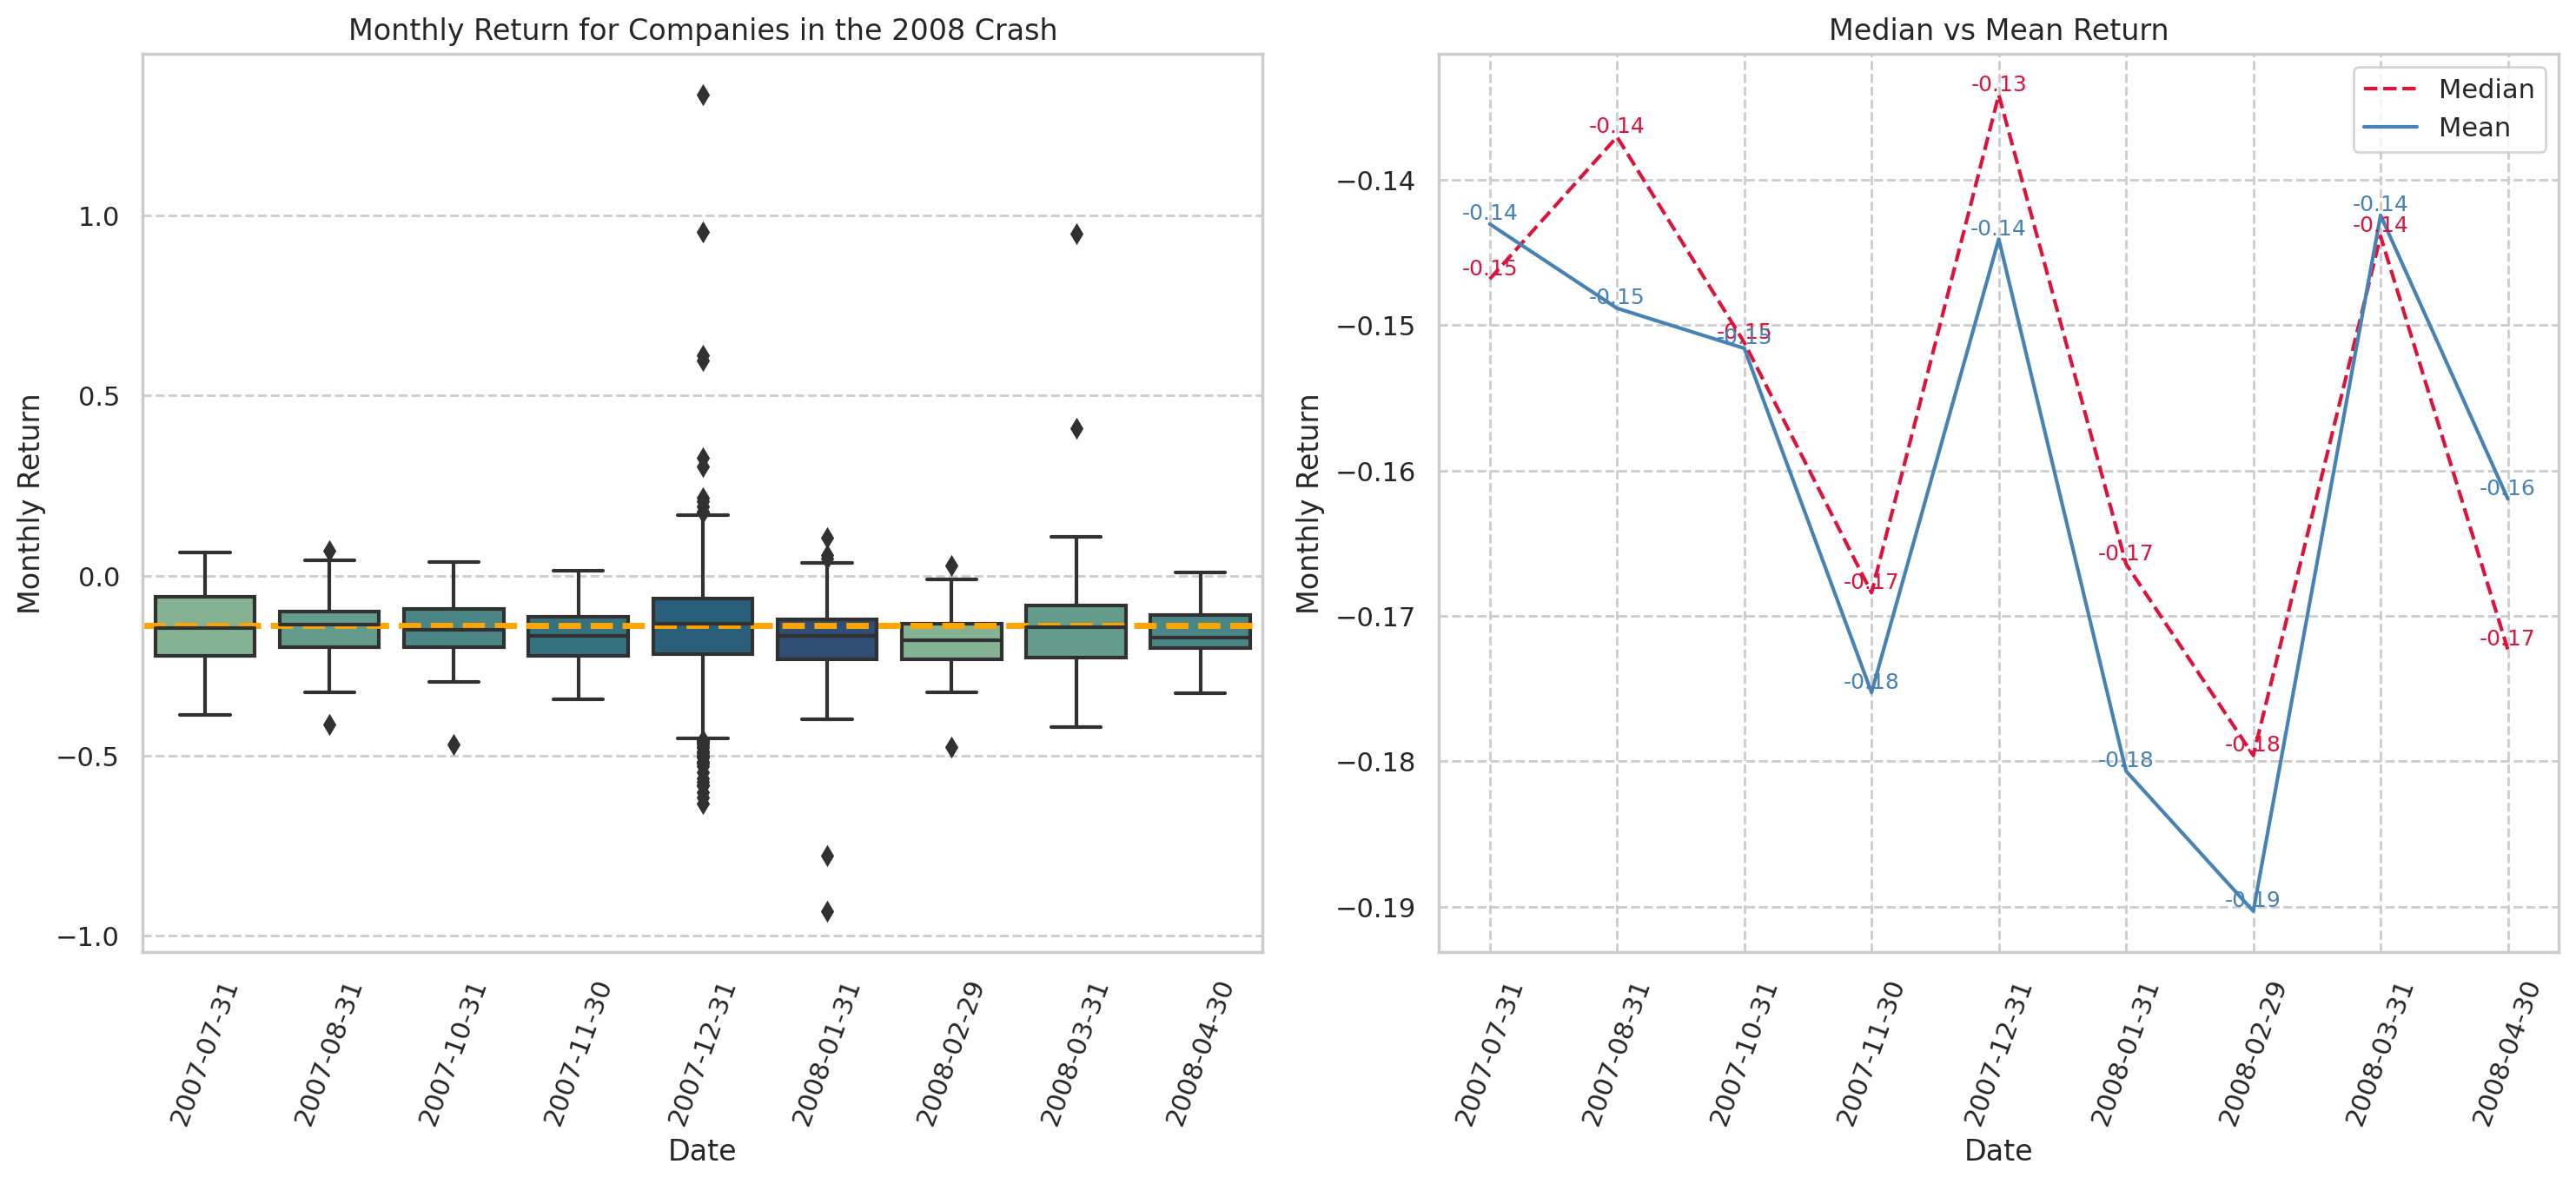

In [184]:
# Analyzing stock returns over the crash period
palette = sns.color_palette('crest')
merged_2008 = merged_2008.sort_values('datadate')
median_return = merged_2008['RET'].median()
mean_return = merged_2008['RET'].mean()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# Boxplot on avg RET distribution
sns.boxplot(x='datadate', y='RET', data=merged_2008, palette=palette, ax=ax1)
ax1.axhline(y=median_return, color='orange', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Return')
ax1.set_xticklabels(labels=merged_2008['datadate'].unique(), rotation=70)
ax1.set_title('Monthly Return for Companies in the 2008 Crash')
# Line plot on avg vs median RET comparison
x = merged_2008['datadate'].unique()
y_median = merged_2008.groupby('datadate')['RET'].median().values
y_mean = merged_2008.groupby('datadate')['RET'].mean().values
ax2.plot(x, y_median, color='crimson', linestyle='--', label='Median')
ax2.plot(x, y_mean, color='steelblue', linestyle='-', label='Mean')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_xticklabels(labels=x, rotation=70)
ax2.set_title('Median vs Mean Return')
ax2.legend()

for i, (xi, yi) in enumerate(zip(x, y_median)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='crimson')
for i, (xi, yi) in enumerate(zip(x, y_mean)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='steelblue')
fig.tight_layout()
plt.show()

- Monthly average returns from $07/2007 - 04/2008$ uniformly fell below 0%, with 12/31/2007 being the most volatile period where many outliers on both ends of the return spectrum (especially on the upside). The orange dotted line depicts the median stock return over the entire crash period, which is also below 0%.
- Stock returns consistently varied in the deeply negative region, from -13% in 12/2007 to -19% in 02/2008, representing the significnt impact of the housing market meltdown in 2008.

#### **Regression $(RET_t)$ Analysis on Various Features**

In [185]:
# Regression 1 - Ratio Analysis
import statsmodels.api as sm
ratio = final_2008[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
X = ratio.fillna(0)
X = sm.add_constant(X)
y = final_2008['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     28.58
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.85e-33
Time:                        03:30:15   Log-Likelihood:                 2220.4
No. Observations:                3174   AIC:                            -4427.
Df Residuals:                    3167   BIC:                            -4384.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1925      0.010    -18.369      0.000      -0.213      -0.172
at             0.0102      0.003      3.989      0.000       0.005       0.015
ROA            0.0109      0.002      5.375      0.000       0.007       0.015
ROE           -0.0141      0.003     -5.230      0.000      -0.019      -0.009
asset_turn    -0.0152      0.003     -5.414      0.000      -0.021      -0.010
net_margin    -0.0010      0.003     -0.333      0.739      -0.007       0.005
debt_asset    -0.0024      0.001     -2.070      0.039      -0.005      -0.000
==============================================================================
Omnibus:                      983.176   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26829.818
Skew:                           0.876   Prob(JB):                         0.00
Kurtosis:                      17.135   Cond. No.                         46.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
# Regression 2 - Industry-Fixed Effect
import statsmodels.api as sm
sector = final_2008.iloc[:, 19:29] #drop gsector_10 as the base comparison
X = sector.fillna(0)
X = sm.add_constant(X)
y = final_2008['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     28.34
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.44e-52
Time:                        03:30:15   Log-Likelihood:                 2272.9
No. Observations:                3174   AIC:                            -4524.
Df Residuals:                    3163   BIC:                            -4457.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1947      0.008    -23.252      0.000      -0.211      -0.178
gsector_15.0     0.0194      0.013      1.521      0.128      -0.006       0.044
gsector_20.0     0.0329      0.010      3.238      0.001       0.013       0.053
gsector_25.0     0.0179      0.010      1.727      0.084      -0.002       0.038
gsector_30.0     0.0992      0.014      7.175      0.000       0.072       0.126
gsector_35.0     0.0541      0.010      5.294      0.000       0.034       0.074
gsector_40.0     0.1013      0.010     10.628      0.000       0.083       0.120
gsector_45.0     0.0267      0.010      2.714      0.007       0.007       0.046
gsector_50.0     0.0172      0.014      1.208      0.227      -0.011       0.045
gsector_55.0     0.1128      0.015      7.296      0.000       0.083       0.143
gsector_60.0     0.0328      0.014      2.305      0.021       0.005       0.061
==============================================================================
Omnibus:                      963.815   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28155.294
Skew:                           0.826   Prob(JB):                         0.00
Kurtosis:                      17.497   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
# Regression 3 - Combined Regression
import statsmodels.api as sm
sector = final_2008.iloc[:, 19:29] #drop gsector_10 as the base comparison
ratio = final_2008[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
risk = final_2008[['smb', 'hml', 'mktrf']]
X = pd.concat([sector, ratio, risk], axis=1).fillna(0)
X = sm.add_constant(X)
y = final_2008['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     20.35
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.71e-66
Time:                        03:30:16   Log-Likelihood:                 2320.2
No. Observations:                3174   AIC:                            -4600.
Df Residuals:                    3154   BIC:                            -4479.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2088      0.014    -15.143      0.000      -0.236      -0.182
gsector_15.0     0.0236      0.013      1.854      0.064      -0.001       0.048
gsector_20.0     0.0353      0.010      3.403      0.001       0.015       0.056
gsector_25.0     0.0275      0.011      2.538      0.011       0.006       0.049
gsector_30.0     0.1030      0.014      7.352      0.000       0.076       0.130
gsector_35.0     0.0626      0.010      5.979      0.000       0.042       0.083
gsector_40.0     0.1031      0.010      9.896      0.000       0.083       0.124
gsector_45.0     0.0291      0.010      2.799      0.005       0.009       0.049
gsector_50.0     0.0267      0.014      1.886      0.059      -0.001       0.055
gsector_55.0     0.1173      0.015      7.611      0.000       0.087       0.148
gsector_60.0     0.0351      0.014      2.454      0.014       0.007       0.063
at              -0.0022      0.003     -0.790      0.430      -0.008       0.003
ROA              0.0123      0.002      6.085      0.000       0.008       0.016
ROE             -0.0125      0.003     -4.548      0.000      -0.018      -0.007
asset_turn      -0.0012      0.003     -0.388      0.698      -0.007       0.005
net_margin       0.0013      0.003      0.450      0.653      -0.005       0.007
debt_asset      -0.0042      0.001     -3.514      0.000      -0.007      -0.002
smb              0.7780      0.506      1.537      0.124      -0.214       1.770
hml             -0.2806      0.325     -0.863      0.388      -0.918       0.357
mktrf            0.0378      0.257      0.147      0.883      -0.466       0.542
==============================================================================
Omnibus:                     1084.130   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33199.983
Skew:                           0.994   Prob(JB):                         0.00
Kurtosis:                      18.719   Cond. No.                     2.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression Comparison Results**: Regressing on characteristics alone has an $Adj R^2$ of 5%, and industry effects have an $Adj R^2$ of 7.9%. Regression based on industry generated improvement on the first model with higher $Adj R^2$. Significant variables in both models are `at`, `ROA`, `ROE`, `asset_turn`, `debt_asset`, `gsector_10`, `gsector_20`, `gsector_30`, `gsector_35`, `gsector_40`, `gsector_45`, `gsector_55`, and `gsector_60` respectively. Numerous industries went under due to systematic risk during the 2008 financial crisis. 

**Regression #3 Interpretation (Industry + Risk Exposure + Ratios):**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}

1. **The 2008 regression model geenrated many statistically significant variables, with an $Adj. R^2$ of 10.4%.** 
1. **Intercept**: On average, during 2008, companies in the **gsector10 industry (Energy)** generated a monthly return of -20.88%, assuming all other variables = 0. We have 3174 observations in total, each representing a ticker symbol in the `final_2008` dataset. 
1. **Industry Coefficients**: Statistically significant variables include `gsector_20~45` and `gsector_55&60`. Industries that differ the most from the baseline Energy benchmark are Utilities, Financials, and Consumer Staples. 
1. **Financial Characteristics**: `ROA`, `ROE`, and `debt_asset` are all significant. A 1% increase in ROA indicates a 1.23% increase in $RET$, so firms that generate more NI given similar level of assets performed better in 2008 on average. A 1% increase in ROE indicates a 1.25% drop in $RET$, which is contradictory to common sense. A 1% increase in debt-to-asset indicates a 0.42% drop in $RET$, meaning that highly levered companies are being punished in returns. 
1. **Fama-French 3 Factors**: None of the risk exposure factors are statistically significant in the 2008 crash period. 
---


### **4. 2020 The Covid Shock (Feb 2020 – March 2020)**

In [188]:
Rt_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/CRSP-2016-2020.csv')
display(Rt_2020['TICKER'].nunique())
crash_data = Rt_2020[(Rt_2020["date"] >= '2020-01-31') & (Rt_2020["date"] <= '2020-03-31')]
crash_return = pd.DataFrame(crash_data.groupby('TICKER')['RET'].mean()).reset_index()
display(crash_return.info())

10634

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7654 entries, 0 to 7653
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  7654 non-null   object 
 1   RET     7654 non-null   float64
dtypes: float64(1), object(1)
memory usage: 119.7+ KB


None

- **`crash_data`**: Keeps only stock returns for 02/2020 - 03/2020 since this is the timeframe for the fourth crash event. This dataset contains 7654 tickers out of the original 10634 tickers.

- **`crash_return`:** Calculates average monthly stock return for period between $02/2020 - 03/2020$ for each ticker. In this dataset, there are 7654 tickers and their respective returns in the crash period. 


In [189]:
Compustat_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/Compustat-2019.csv')
# merge 2 df on ticker
merged_2020 = pd.merge(crash_return, Compustat_2020, left_on='TICKER', right_on='tic')
merged_2020 = merged_2020.drop(['gvkey', 'consol', 'popsrc', 'datafmt', 'tic', 'curcd', 'costat'], axis=1)
merged_2020['se'] = merged_2020['at'] - merged_2020['lt']
display(merged_2020.iloc[5:7])
display(merged_2020.info())

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
5,AAME,0.031242,2019-12-31,2019,INDL,NaN,377.626,12.893,195.460,39.413,NaN,259.232,-0.386,46.479,198.179,118.394
6,AAN,-0.239272,2019-12-31,2019,INDL,NaN,1940.331,48.773,83.791,676.837,NaN,1102.550,28.099,NaN,1784.477,837.781


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4099 entries, 0 to 4098
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TICKER    4099 non-null   object 
 1   RET       4099 non-null   float64
 2   datadate  4099 non-null   object 
 3   fyear     4099 non-null   int64  
 4   indfmt    4099 non-null   object 
 5   act       3174 non-null   float64
 6   at        4099 non-null   float64
 7   che       4099 non-null   float64
 8   cogs      4099 non-null   float64
 9   dltt      4089 non-null   float64
 10  lct       3177 non-null   float64
 11  lt        4092 non-null   float64
 12  ni        4099 non-null   float64
 13  re        3990 non-null   float64
 14  sale      4099 non-null   float64
 15  se        4092 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 544.4+ KB


None

- After merging on ticker symbol, we have 4099 companies left compared to the original 7654 companies in `crash_return`. Columns with null values are `act`, `dltt`, `lct`, `lt`, `se`, and `re`. **Since financial data have relationships with one another, missing values can be predicted using other columns through regression.**

#### **Regression Imputation**

In [190]:
#create copy of merged_2020 df for imputation of missing values
reg_data = merged_2020[['TICKER', 'datadate', 'act', 'cogs', 'dltt', 'lct', 're', 'che', 'lt', 'ni', 'sale', 'se']].copy()
reg_data = reg_data.dropna(subset=['cogs', 'che', 'ni', 'sale']) #independent variables
complete_data = reg_data.dropna() #drop null values in training set
missing_data = reg_data[reg_data.isna().any(axis=1)] #use rows with null for training set
X_cols = ['cogs', 'che', 'ni', 'sale']
y_cols = ['act', 'dltt', 'lct', 'lt', 'se', 're']
reg_model = LinearRegression()
reg_model.fit(complete_data[X_cols], complete_data[y_cols])
imputed_values = reg_model.predict(missing_data[X_cols])
merged_2020.loc[missing_data.index, y_cols] = imputed_values
display(merged_2020.iloc[5:7])

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
5,AAME,0.031242,2019-12-31,2019,INDL,358.067889,377.626,12.893,195.460,734.574050,177.983479,1112.845634,-0.386,-138.852667,198.179,630.455778
6,AAN,-0.239272,2019-12-31,2019,INDL,696.219736,1940.331,48.773,83.791,2394.459138,821.044640,4156.987697,28.099,259.650121,1784.477,2025.711992


- **Observation:** Previously, before the regression imputation of `merged_2020` df, we saw that `act`, `cogs`, `dltt`, `lct`, `lt`, `se`, `re` all have NaNs. Now, with company-specific regression imputation, they have 4099 complete observations. 
    - ***Rationality Check:*** For example, tickers `AAME` and `AAN` all have missing values in `act` and `lct`. After regression imputation, it makes sense to see a smaller current assets compared to total assets, and a smaller current liabilities compared to total liabilities. 

#### **Combine with FF-3 Factors & GSECTOR Data:**

In [191]:
FF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/FF-Factors-1983-2022.csv')
industry_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/GSECTOR-2019.csv')
industry_2020 = industry_2020.iloc[:, 2:]
merged_2020 = pd.merge(merged_2020, FF, left_on="datadate", right_on='date')
merged_2020 = pd.merge(merged_2020, industry_2020, left_on="TICKER", right_on="tic")
merged_2020 = pd.get_dummies(merged_2020, columns=['gsector'])
merged_2020.loc[:, 'gsector_10.0':] = merged_2020.loc[:, 'gsector_10.0':].astype('float64')
final_2020 = merged_2020.drop(columns=["fyear", "indfmt", "date", "tic"])

- `final_2020` now contains stock returns $Ret$ with respect to financials, risk exposures, and gsector information. Now we calculate ratios based on this data. 

#### **Create Financial Ratios: $log(Asset), ROA, ROE, Asset \ Turnover, Net \ Profit \ Margin, and \ LT \ Debt/Asset$**

In [192]:
# Size differential log(Assets)
final_2020['at'] = np.log(final_2020['at'])
# ROA
final_2020['ROA'] = np.log((final_2020['ni']+1)/(final_2020['at']+1))
# ROE
final_2020['ROE'] = np.log((final_2020['ni']+1)/(final_2020['se']+1))
# Asset turnover
final_2020['asset_turn'] = np.log((final_2020['sale']+1)/(final_2020['at']+1))
# Net profit margin
final_2020['net_margin'] = np.log((final_2020['ni']+1)/(final_2020['sale']+1))
# Long Tem Debt to Total Assets Ratio
final_2020['debt_asset'] = np.log((final_2020['dltt']+1)/(final_2020['at']+1))
display(final_2020[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,3838.000000,2507.000000,2546.000000,3838.000000,2507.000000,3817.000000
mean,7.228710,2.416457,-2.298611,4.133126,-2.360291,3.439092
std,2.286371,1.868771,1.322255,2.131505,1.169416,2.429537
min,0.140631,-4.678798,-8.702738,-1.824325,-8.894716,-2.259062
25%,5.773886,1.174346,-2.963161,2.742476,-2.952412,1.681756
50%,7.339200,2.390157,-2.204594,4.242193,-2.233607,4.417752
75%,8.723106,3.664614,-1.640126,5.599789,-1.531638,4.975315
max,14.941459,8.299998,5.995770,10.571036,2.302745,9.407007


- Compared to the original 4099 company observations, after merging with FF-3 Factor data and GSECTOR info we only have 3838 observations remaining. 
- For all ratios, their maximum values are much higher than the 75th percentile results (same pattern is true for min and 25th percentile), so we need to winsorize these ratios on the 1th and 99th boundaries (especially true for Asset Turnover and debt-to-asset ratios). We should only winsorize outlier ratios not outliers themselves. 

In [193]:
# Winsorize financial ratios
from scipy.stats.mstats import winsorize
final_2020['at'] = winsorize(final_2020['at'], limits=(0.01,0.01))
final_2020['ROA'] = winsorize(final_2020['ROA'], limits=(0.01,0.01))
final_2020['ROE'] = winsorize(final_2020['ROE'], limits=(0.01,0.01))
final_2020['asset_turn'] = winsorize(final_2020['asset_turn'], limits=(0.01,0.01))
final_2020['net_margin'] = winsorize(final_2020['net_margin'], limits=(0.01,0.01))
final_2020['debt_asset'] = winsorize(final_2020['debt_asset'], limits=(0.01,0.01))
display(final_2020[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,3838.000000,2507.000000,2546.000000,3838.000000,2507.000000,3838.000000
mean,7.224762,2.429214,-2.285442,4.130795,-2.345055,3.466046
std,2.244584,1.834731,1.279641,2.110568,1.113702,2.443341
min,2.006333,-1.732258,-5.684762,-1.136801,-5.610662,-1.877753
25%,5.773886,1.174346,-2.963161,2.742476,-2.952412,1.706450
50%,7.339200,2.390157,-2.204594,4.242193,-2.233607,4.433254
75%,8.723106,3.664614,-1.640126,5.599789,-1.531638,4.984194
max,12.591352,8.299998,5.995770,8.736922,2.302745,8.377470


- **Pre and post-winsorization comparison:** Extreme values, especially in Asset Turnover, are trimmed to the 99th percentile instead of being deleted, and the numbers are more reasonable when compared to the 75th percentile results. In the 2020 COVID crisis, more volatility is observed in debt-to-asset ratio. 

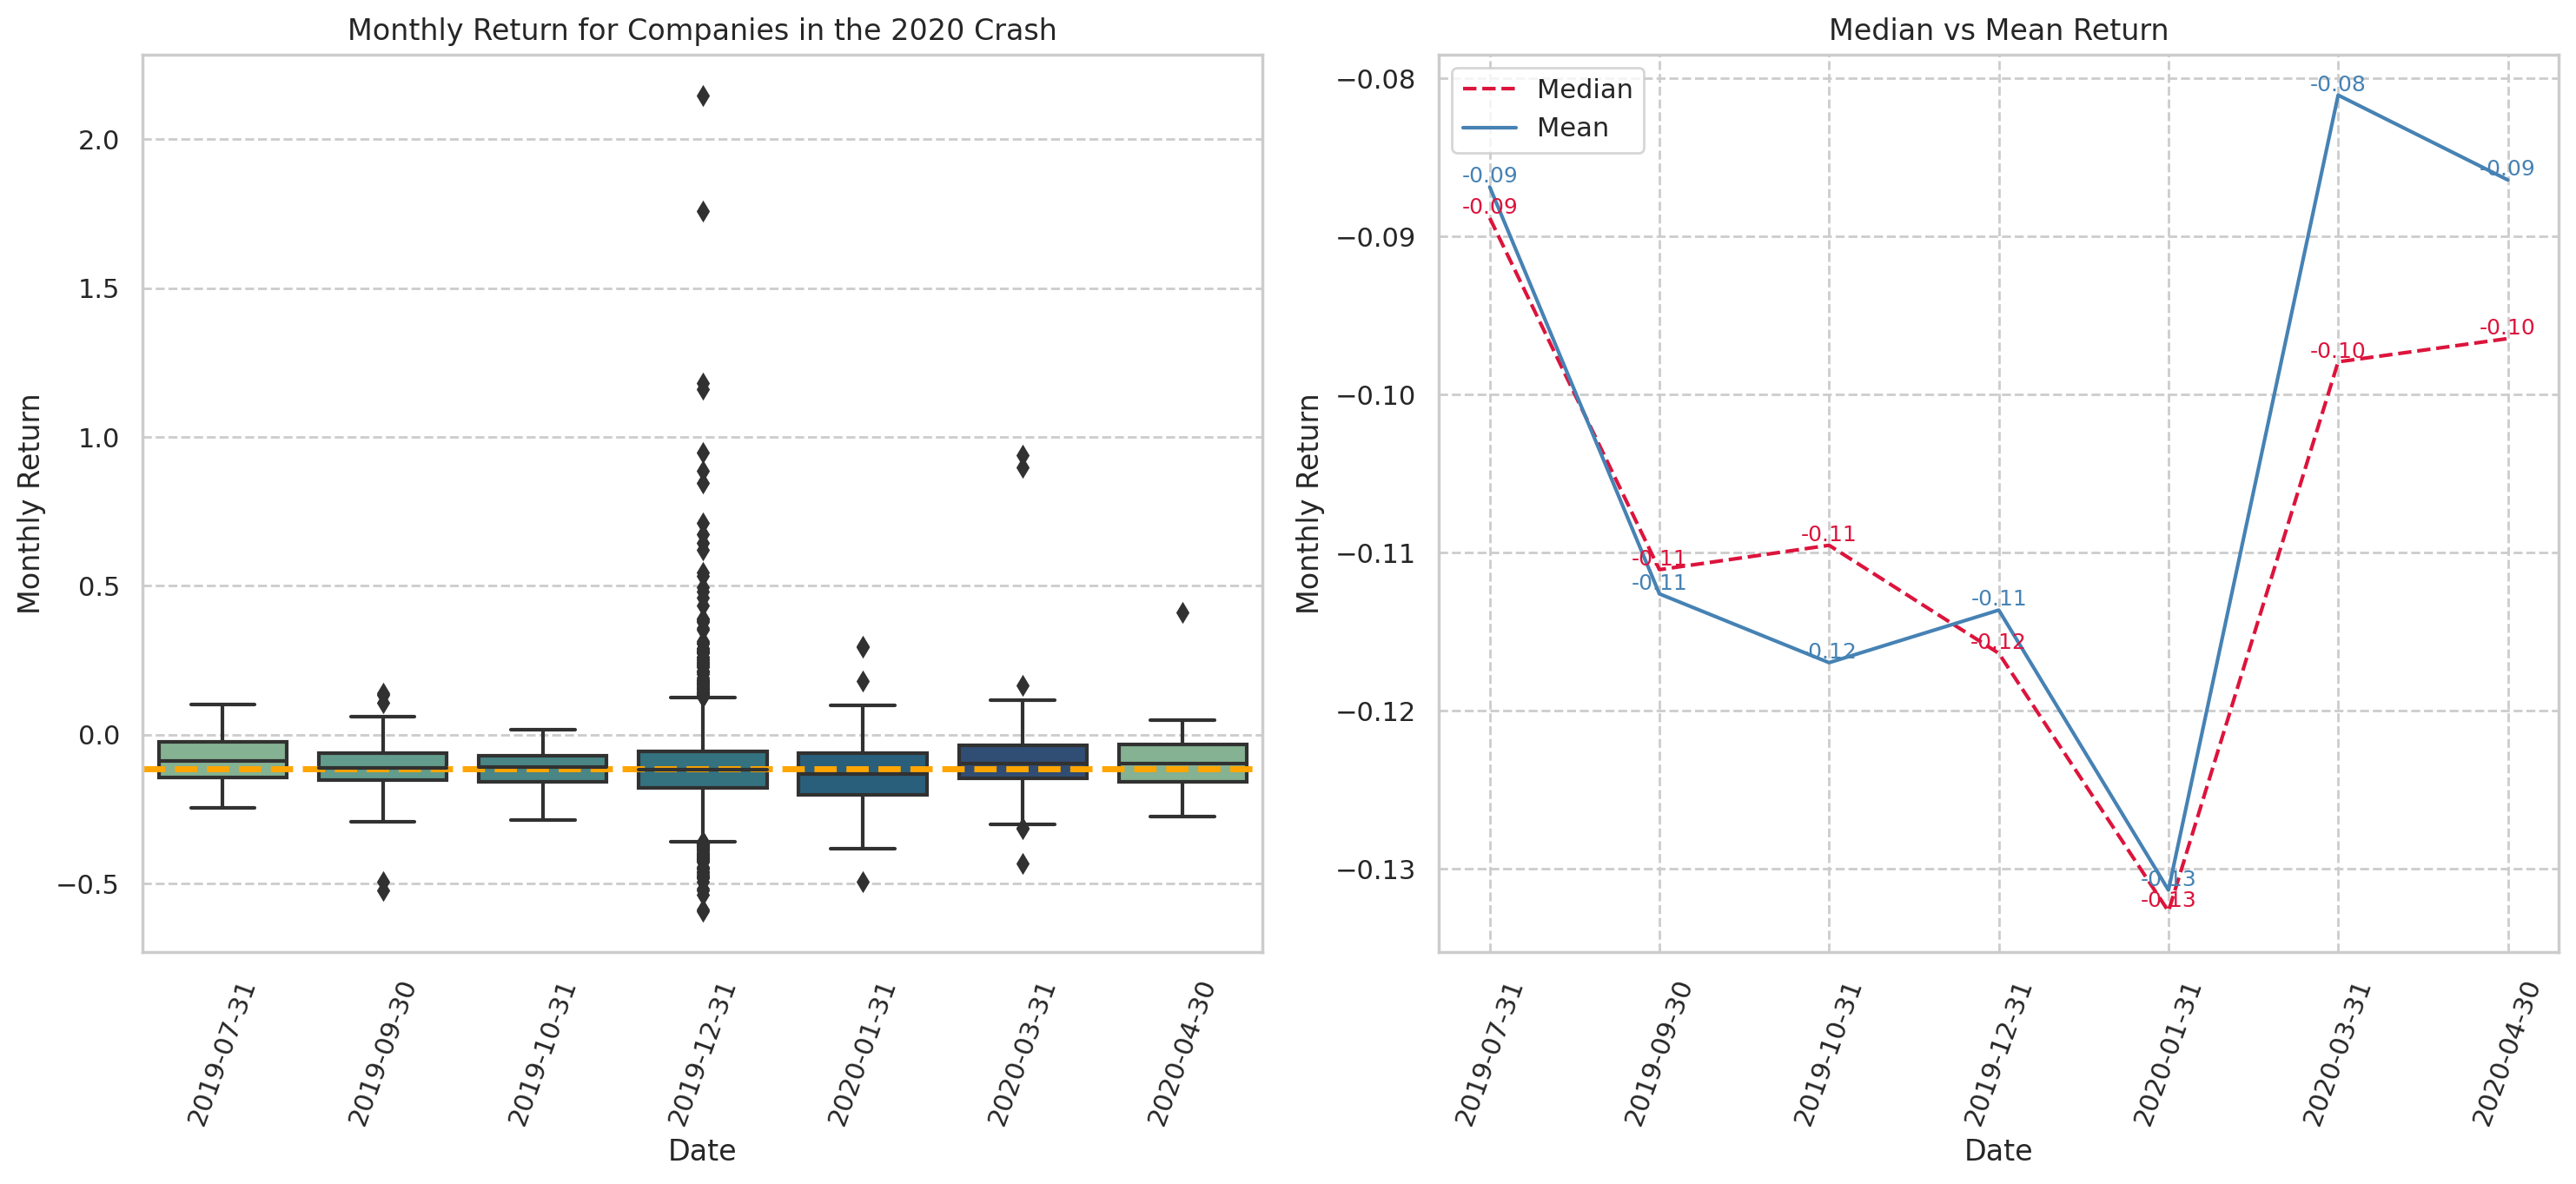

In [194]:
# Analyzing stock returns over the crash period
palette = sns.color_palette('crest')
merged_2020 = merged_2020.sort_values('datadate')
median_return = merged_2020['RET'].median()
mean_return = merged_2020['RET'].mean()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# Boxplot on avg RET distribution
sns.boxplot(x='datadate', y='RET', data=merged_2020, palette=palette, ax=ax1)
ax1.axhline(y=median_return, color='orange', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Return')
ax1.set_xticklabels(labels=merged_2020['datadate'].unique(), rotation=70)
ax1.set_title('Monthly Return for Companies in the 2020 Crash')
# Line plot on avg vs median RET comparison
x = merged_2020['datadate'].unique()
y_median = merged_2020.groupby('datadate')['RET'].median().values
y_mean = merged_2020.groupby('datadate')['RET'].mean().values
ax2.plot(x, y_median, color='crimson', linestyle='--', label='Median')
ax2.plot(x, y_mean, color='steelblue', linestyle='-', label='Mean')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_xticklabels(labels=x, rotation=70)
ax2.set_title('Median vs Mean Return')
ax2.legend()

for i, (xi, yi) in enumerate(zip(x, y_median)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='crimson')
for i, (xi, yi) in enumerate(zip(x, y_mean)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='steelblue')
fig.tight_layout()
plt.show()

- Monthly average returns from $07/2019 - 04/2020$ are slightly below 0% on average, and the median return ($R_{median}$) represented by the orange dotted line also fell below 0%. **According to the data, the start of the COVID pandemic didn't seem to provoke a rapid sell-off and stock market crash at the beginning few months in 2020, which is a bit contradictory.** If we have more data beyond 04/2020 then maybe we will see a rapidly worsening pattern. 
- Market experienced continual sell-off from 07/2019-01/2020, with median $R_i$ dropping from -9% to -13%.

#### **Regression $(RET_t)$ Analysis on Various Features**

In [195]:
# Regression 1 - Ratio Analysis
import statsmodels.api as sm
ratio = final_2020[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
X = ratio.fillna(0)
X = sm.add_constant(X)
y = final_2020['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     36.85
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.16e-43
Time:                        03:30:18   Log-Likelihood:                 2523.2
No. Observations:                3838   AIC:                            -5032.
Df Residuals:                    3831   BIC:                            -4989.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0459      0.010     -4.731      0.000      -0.065      -0.027
at            -0.0030      0.002     -1.270      0.204      -0.008       0.002
ROA            0.0147      0.002      9.032      0.000       0.012       0.018
ROE            0.0013      0.002      0.570      0.569      -0.003       0.006
asset_turn    -0.0099      0.002     -4.515      0.000      -0.014      -0.006
net_margin    -0.0003      0.003     -0.128      0.898      -0.005       0.005
debt_asset    -0.0075      0.001     -5.030      0.000      -0.010      -0.005
==============================================================================
Omnibus:                     3311.345   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           350766.757
Skew:                           3.575   Prob(JB):                         0.00
Kurtosis:                      49.285   Cond. No.                         50.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
# Regression 2 - Industry-Fixed Effect
import statsmodels.api as sm
sector = final_2020.iloc[:, 19:29] #drop gsector_10 as the base comparison
X = sector.fillna(0)
X = sm.add_constant(X)
y = final_2020['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     59.78
Date:                Sat, 06 May 2023   Prob (F-statistic):          4.64e-113
Time:                        03:30:18   Log-Likelihood:                 2694.0
No. Observations:                3838   AIC:                            -5366.
Df Residuals:                    3827   BIC:                            -5297.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2373      0.007    -32.468      0.000      -0.252      -0.223
gsector_15.0     0.0996      0.011      8.801      0.000       0.077       0.122
gsector_20.0     0.1177      0.009     12.971      0.000       0.100       0.136
gsector_25.0     0.0851      0.009      9.043      0.000       0.067       0.104
gsector_30.0     0.1804      0.013     13.959      0.000       0.155       0.206
gsector_35.0     0.1837      0.009     21.088      0.000       0.167       0.201
gsector_40.0     0.1128      0.009     13.215      0.000       0.096       0.129
gsector_45.0     0.1592      0.009     17.343      0.000       0.141       0.177
gsector_50.0     0.1396      0.011     12.159      0.000       0.117       0.162
gsector_55.0     0.1802      0.014     12.480      0.000       0.152       0.209
gsector_60.0     0.1164      0.011     10.519      0.000       0.095       0.138
==============================================================================
Omnibus:                     3730.961   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           526869.658
Skew:                           4.288   Prob(JB):                         0.00
Kurtosis:                      59.755   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
# Regression 3 - Combined Regression
import statsmodels.api as sm
sector = final_2020.iloc[:, 19:29] #drop gsector_10 as the base comparison
ratio = final_2020[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
risk = final_2020[['smb', 'hml', 'mktrf']]
X = pd.concat([sector, ratio, risk], axis=1).fillna(0)
X = sm.add_constant(X)
y = final_2020['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     37.78
Date:                Sat, 06 May 2023   Prob (F-statistic):          1.54e-127
Time:                        03:30:18   Log-Likelihood:                 2746.1
No. Observations:                3838   AIC:                            -5452.
Df Residuals:                    3818   BIC:                            -5327.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1744      0.012    -14.304      0.000      -0.198      -0.151
gsector_15.0     0.0995      0.011      8.841      0.000       0.077       0.122
gsector_20.0     0.1128      0.009     12.290      0.000       0.095       0.131
gsector_25.0     0.0825      0.010      8.491      0.000       0.063       0.102
gsector_30.0     0.1753      0.013     13.443      0.000       0.150       0.201
gsector_35.0     0.1645      0.009     18.126      0.000       0.147       0.182
gsector_40.0     0.1039      0.009     11.346      0.000       0.086       0.122
gsector_45.0     0.1474      0.009     15.688      0.000       0.129       0.166
gsector_50.0     0.1354      0.011     11.878      0.000       0.113       0.158
gsector_55.0     0.1794      0.014     12.407      0.000       0.151       0.208
gsector_60.0     0.1095      0.011      9.766      0.000       0.087       0.131
at              -0.0053      0.002     -2.158      0.031      -0.010      -0.000
ROA              0.0117      0.002      7.516      0.000       0.009       0.015
ROE             -0.0039      0.002     -1.664      0.096      -0.009       0.001
asset_turn      -0.0055      0.002     -2.240      0.025      -0.010      -0.001
net_margin       0.0030      0.003      1.172      0.241      -0.002       0.008
debt_asset      -0.0031      0.001     -2.143      0.032      -0.006      -0.000
smb              0.3289      0.349      0.942      0.346      -0.355       1.013
hml             -0.1187      0.100     -1.190      0.234      -0.314       0.077
mktrf           -0.1376      0.141     -0.977      0.329      -0.414       0.139
==============================================================================
Omnibus:                     3681.715   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516963.294
Skew:                           4.189   Prob(JB):                         0.00
Kurtosis:                      59.236   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression Comparison Results**: Regressing on characteristics alone has an $Adj R^2$ of 5.3%, and industry effects have an $Adj R^2$ of 13.3%. Regression based on industry generated improvement on the first model with higher $Adj R^2$. Significant variables in both models are `ROA`, `asset_turn`, `debt_asset`, and all `gsector` variables have p-values < 0.05. This suggests COVID's systematic impact on all industries. 

**Regression #3 Interpretation (Industry + Risk Exposure + Ratios):**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}

1. **The 2020 COVID regression model generated many statistically significant variables, with an $Adj. R^2$ of 15.4%.** 
1. **Intercept**: On average, during 2020, companies in the **gsector10 industry (Energy)** generated a monthly return of -17.44%, assuming all other variables = 0. We have 3838 observations in total, each representing a ticker symbol in the `final_2020` dataset. 
1. **Industry Coefficients**: All industry variables are statistically significant. Industries that differ the most from the baseline Energy benchmark are Utilities and Consumer Staples. This may be attributed to the fact that people still need to consume food and electricities during the pandemic. 
1. **Financial Characteristics**: `at`, `ROA`, `asset_turn`, and `debt_asset` are all significant. A 1% increase in ROA indicates a 1.17% increase in $RET$, so firms that generate more NI given similar level of assets performed better in 2020 on average. A 1% increase in debt-to-asset indicates a 0.31% drop in $RET$, meaning that highly levered companies are being punished in returns. 
1. **Fama-French 3 Factors**: None of the risk exposure factors are statistically significant in the 2020 crash period. 
---


### **5. 2022 “The End of Easy Money” (Jan 2022 – Sep 2022)**

In [198]:
Rt_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/CRSP-2018-2022.csv')
display(Rt_2022['TICKER'].nunique())
crash_data = Rt_2022[(Rt_2022["date"] >= '2021-12-31') & (Rt_2022["date"] <= '2022-09-31')]
crash_return = pd.DataFrame(crash_data.groupby('TICKER')['RET'].mean()).reset_index()
display(crash_return.info())

12482

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  9994 non-null   object 
 1   RET     9994 non-null   float64
dtypes: float64(1), object(1)
memory usage: 156.3+ KB


None

- **`crash_data`**: Keeps only stock returns for 01/2022-09/2022 since this is the timeframe for the fifth crash event. This dataset contains 9994 tickers out of the original 12482 tickers.

- **`crash_return`:** Calculates average monthly stock return for period between $01/2022-09/2022$ for each ticker. In this dataset, there are 9994 tickers and their respective returns in the crash period. 


In [199]:
Compustat_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/Compustat-2021.csv')
merged_2022 = pd.merge(crash_return, Compustat_2022, left_on='TICKER', right_on='tic')
merged_2022 = merged_2022.drop(['gvkey', 'consol', 'popsrc', 'datafmt', 'tic', 'curcd', 'costat'], axis=1)
# B/S equation: SE = Assets - Liabilities
merged_2022['se'] = merged_2022['at'] - merged_2022['lt']
display(merged_2022.iloc[4:8])
display(merged_2022.info())

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
4,AAIC,-0.024652,2021-12-31,2021,INDL,NaN,803.036,531.935,12.333,125.680,NaN,578.909,-9.515,-1842.703,12.590,224.127
5,AAL,-0.031668,2021-12-31,2021,INDL,17336.0,66467.000,13421.000,27969.000,42181.000,19006.0,73807.000,-1993.000,-14580.000,29882.000,-7340.000
6,AAME,-0.015658,2021-12-31,2021,INDL,NaN,402.286,26.487,191.862,38.116,NaN,261.000,4.281,68.952,199.554,141.286
7,AAN,-0.071295,2021-12-31,2021,INDL,NaN,1441.265,22.832,97.701,309.834,NaN,723.099,109.934,97.807,1845.504,718.166


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4889 entries, 0 to 4888
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TICKER    4889 non-null   object 
 1   RET       4889 non-null   float64
 2   datadate  4889 non-null   object 
 3   fyear     4889 non-null   int64  
 4   indfmt    4889 non-null   object 
 5   act       3949 non-null   float64
 6   at        4889 non-null   float64
 7   che       4889 non-null   float64
 8   cogs      4889 non-null   float64
 9   dltt      4876 non-null   float64
 10  lct       3952 non-null   float64
 11  lt        4879 non-null   float64
 12  ni        4889 non-null   float64
 13  re        4782 non-null   float64
 14  sale      4889 non-null   float64
 15  se        4879 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 649.3+ KB


None

- After merging on ticker symbol, we have 4889 companies left compared to the original 9994 companies in `crash_return`. Columns with null values are `act`, `dltt`, `lct`, `lt`, `se`, and `re`. **Since financial data have relationships with one another, missing values can be predicted using other columns through regression.**

#### **Regression Imputation**

In [200]:
#create copy of merged_2022 df for imputation of missing values
reg_data = merged_2022[['TICKER', 'datadate', 'act', 'cogs', 'dltt', 'lct', 're', 'che', 'lt', 'ni', 'sale', 'se']].copy()
reg_data = reg_data.dropna(subset=['cogs', 'che', 'ni', 'sale']) #independent variables
complete_data = reg_data.dropna() #drop null values in training set
missing_data = reg_data[reg_data.isna().any(axis=1)] #use rows with null for training set
X_cols = ['cogs', 'che', 'ni', 'sale']
y_cols = ['act', 'dltt', 'lct', 'lt', 'se', 're']
reg_model = LinearRegression()
reg_model.fit(complete_data[X_cols], complete_data[y_cols])
imputed_values = reg_model.predict(missing_data[X_cols])
merged_2022.loc[missing_data.index, y_cols] = imputed_values
display(merged_2022.iloc[4:8])

,TICKER,RET,datadate,fyear,indfmt,act,at,che,cogs,dltt,lct,lt,ni,re,sale,se
4,AAIC,-0.024652,2021-12-31,2021,INDL,1074.484529,803.036,531.935,12.333,810.179056,505.305616,1582.308382,-9.515,-98.060740,12.590,1045.124959
5,AAL,-0.031668,2021-12-31,2021,INDL,17336.000000,66467.000,13421.000,27969.000,42181.000000,19006.000000,73807.000000,-1993.000,-14580.000000,29882.000,-7340.000000
6,AAME,-0.015658,2021-12-31,2021,INDL,483.108740,402.286,26.487,191.862,901.385433,282.454722,1473.266014,4.281,-162.467161,199.554,653.390162
7,AAN,-0.071295,2021-12-31,2021,INDL,541.259815,1441.265,22.832,97.701,2329.572615,622.509137,3575.424760,109.934,123.041549,1845.504,1580.895418


- **Observation:** Previously, before the regression imputation of `merged_2022` df, we saw that `act`, `cogs`, `dltt`, `lct`, `lt`, `se`, `re` all have NaNs. Now, with company-specific regression imputation, they have 4889 complete observations. 
    - ***Rationality Check:*** For example, tickers `AAIC`, `AAME` and `AAN` all have missing values in `act` and `lct`. After regression imputation, it makes sense to see a smaller current assets compared to total assets, and a smaller current liabilities compared to total liabilities. 
- We need to further winsorize variables with min of 0 to avoid infinite values in calculating ratios. 

#### **Combine with FF-3 Factors & GSECTOR Data:**

In [201]:
FF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/FF-Factors-1983-2022.csv')
industry_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA870 Financial Analytics/Project/GSECTOR-2021.csv')
industry_2022 = industry_2022.iloc[:, 2:]
merged_2022 = pd.merge(merged_2022, FF, left_on="datadate", right_on='date')
merged_2022 = pd.merge(merged_2022, industry_2022, left_on="TICKER", right_on="tic")
merged_2022 = pd.get_dummies(merged_2022, columns=['gsector'])
merged_2022.loc[:, 'gsector_10.0':] = merged_2022.loc[:, 'gsector_10.0':].astype('float64')
final_2022 = merged_2022.drop(columns=["fyear", "indfmt", "date", "tic"])

- `final_2022` now contains stock returns $Ret$ with respect to financials, risk exposures, and gsector information. Now we calculate ratios based on this data. 

#### **Create Financial Ratios: $log(Asset), ROA, ROE, Asset \ Turnover, Net \ Profit \ Margin, and \ LT \ Debt/Asset$**

In [202]:
# Size differential log(Assets)
final_2022['at'] = np.log(final_2022['at'])
# ROA
final_2022['ROA'] = np.log((final_2022['ni']+1)/(final_2022['at']+1))
# ROE
final_2022['ROE'] = np.log((final_2022['ni']+1)/(final_2022['se']+1))
# Asset turnover
final_2022['asset_turn'] = np.log((final_2022['sale']+1)/(final_2022['at']+1))
# Net profit margin
final_2022['net_margin'] = np.log((final_2022['ni']+1)/(final_2022['sale']+1))
# Long Tem Debt to Total Assets Ratio
final_2022['debt_asset'] = np.log((final_2022['dltt']+1)/(final_2022['at']+1))
display(final_2022[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,4781.000000,2936.000000,2982.000000,4781.000000,2936.000000,4753.000000
mean,7.138000,2.590999,-2.124083,3.917922,-2.165653,3.144635
std,2.272235,1.961163,1.375782,2.267110,1.220919,2.588447
min,-0.193585,-4.673898,-8.381175,-2.024303,-8.170340,-2.275615
25%,5.608548,1.288891,-2.833773,2.426716,-2.800344,1.033068
50%,7.199047,2.619747,-2.034564,4.073219,-2.085996,3.996325
75%,8.664039,3.916001,-1.381793,5.454791,-1.327309,4.920189
max,15.135549,8.835882,5.292888,10.657442,4.516002,9.412589


- Compared to the original 4889 company observations, after merging with FF-3 Factor data and GSECTOR info we only have 4781 observations remaining. 
- For all ratios, their maximum values are much higher than the 75th percentile results (same pattern is true for min and 25th percentile), so we need to winsorize these ratios on the 1th and 99th boundaries (especially true for Total Assets & Asset Turnover). We should only winsorize outlier ratios not outliers themselves. 

In [203]:
# Winsorize financial ratios
from scipy.stats.mstats import winsorize
final_2022['at'] = winsorize(final_2022['at'], limits=(0.01,0.01))
final_2022['ROA'] = winsorize(final_2022['ROA'], limits=(0.01,0.01))
final_2022['ROE'] = winsorize(final_2022['ROE'], limits=(0.01,0.01))
final_2022['asset_turn'] = winsorize(final_2022['asset_turn'], limits=(0.01,0.01))
final_2022['net_margin'] = winsorize(final_2022['net_margin'], limits=(0.01,0.01))
final_2022['debt_asset'] = winsorize(final_2022['debt_asset'], limits=(0.01,0.01))
display(final_2022[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']].describe())

,at,ROA,ROE,asset_turn,net_margin,debt_asset
count,4781.000000,2936.000000,2982.000000,4781.000000,2936.000000,4781.000000
mean,7.135306,2.605841,-2.108231,3.914313,-2.154755,3.175074
std,2.229241,1.922201,1.327188,2.246482,1.184111,2.606453
min,2.159292,-1.671468,-5.408424,-1.375647,-5.581504,-1.918930
25%,5.608548,1.288891,-2.833773,2.426716,-2.800344,1.057192
50%,7.199047,2.619747,-2.034564,4.073219,-2.085996,4.017349
75%,8.664039,3.916001,-1.381793,5.454791,-1.327309,4.935854
max,12.585406,8.835882,5.292888,8.767951,4.516002,8.417055


- **Pre and post-winsorization comparison:** Extreme values, especially in Asset Turnover, are trimmed to the 99th percentile instead of being deleted, and the numbers are more reasonable when compared to the 75th percentile results. In the 2022 crash, debt-to-asset ratio again exhibited great volatility, suggesting firms with high financial leverage are more likely to experience volatile returns during high interest rate environment. 

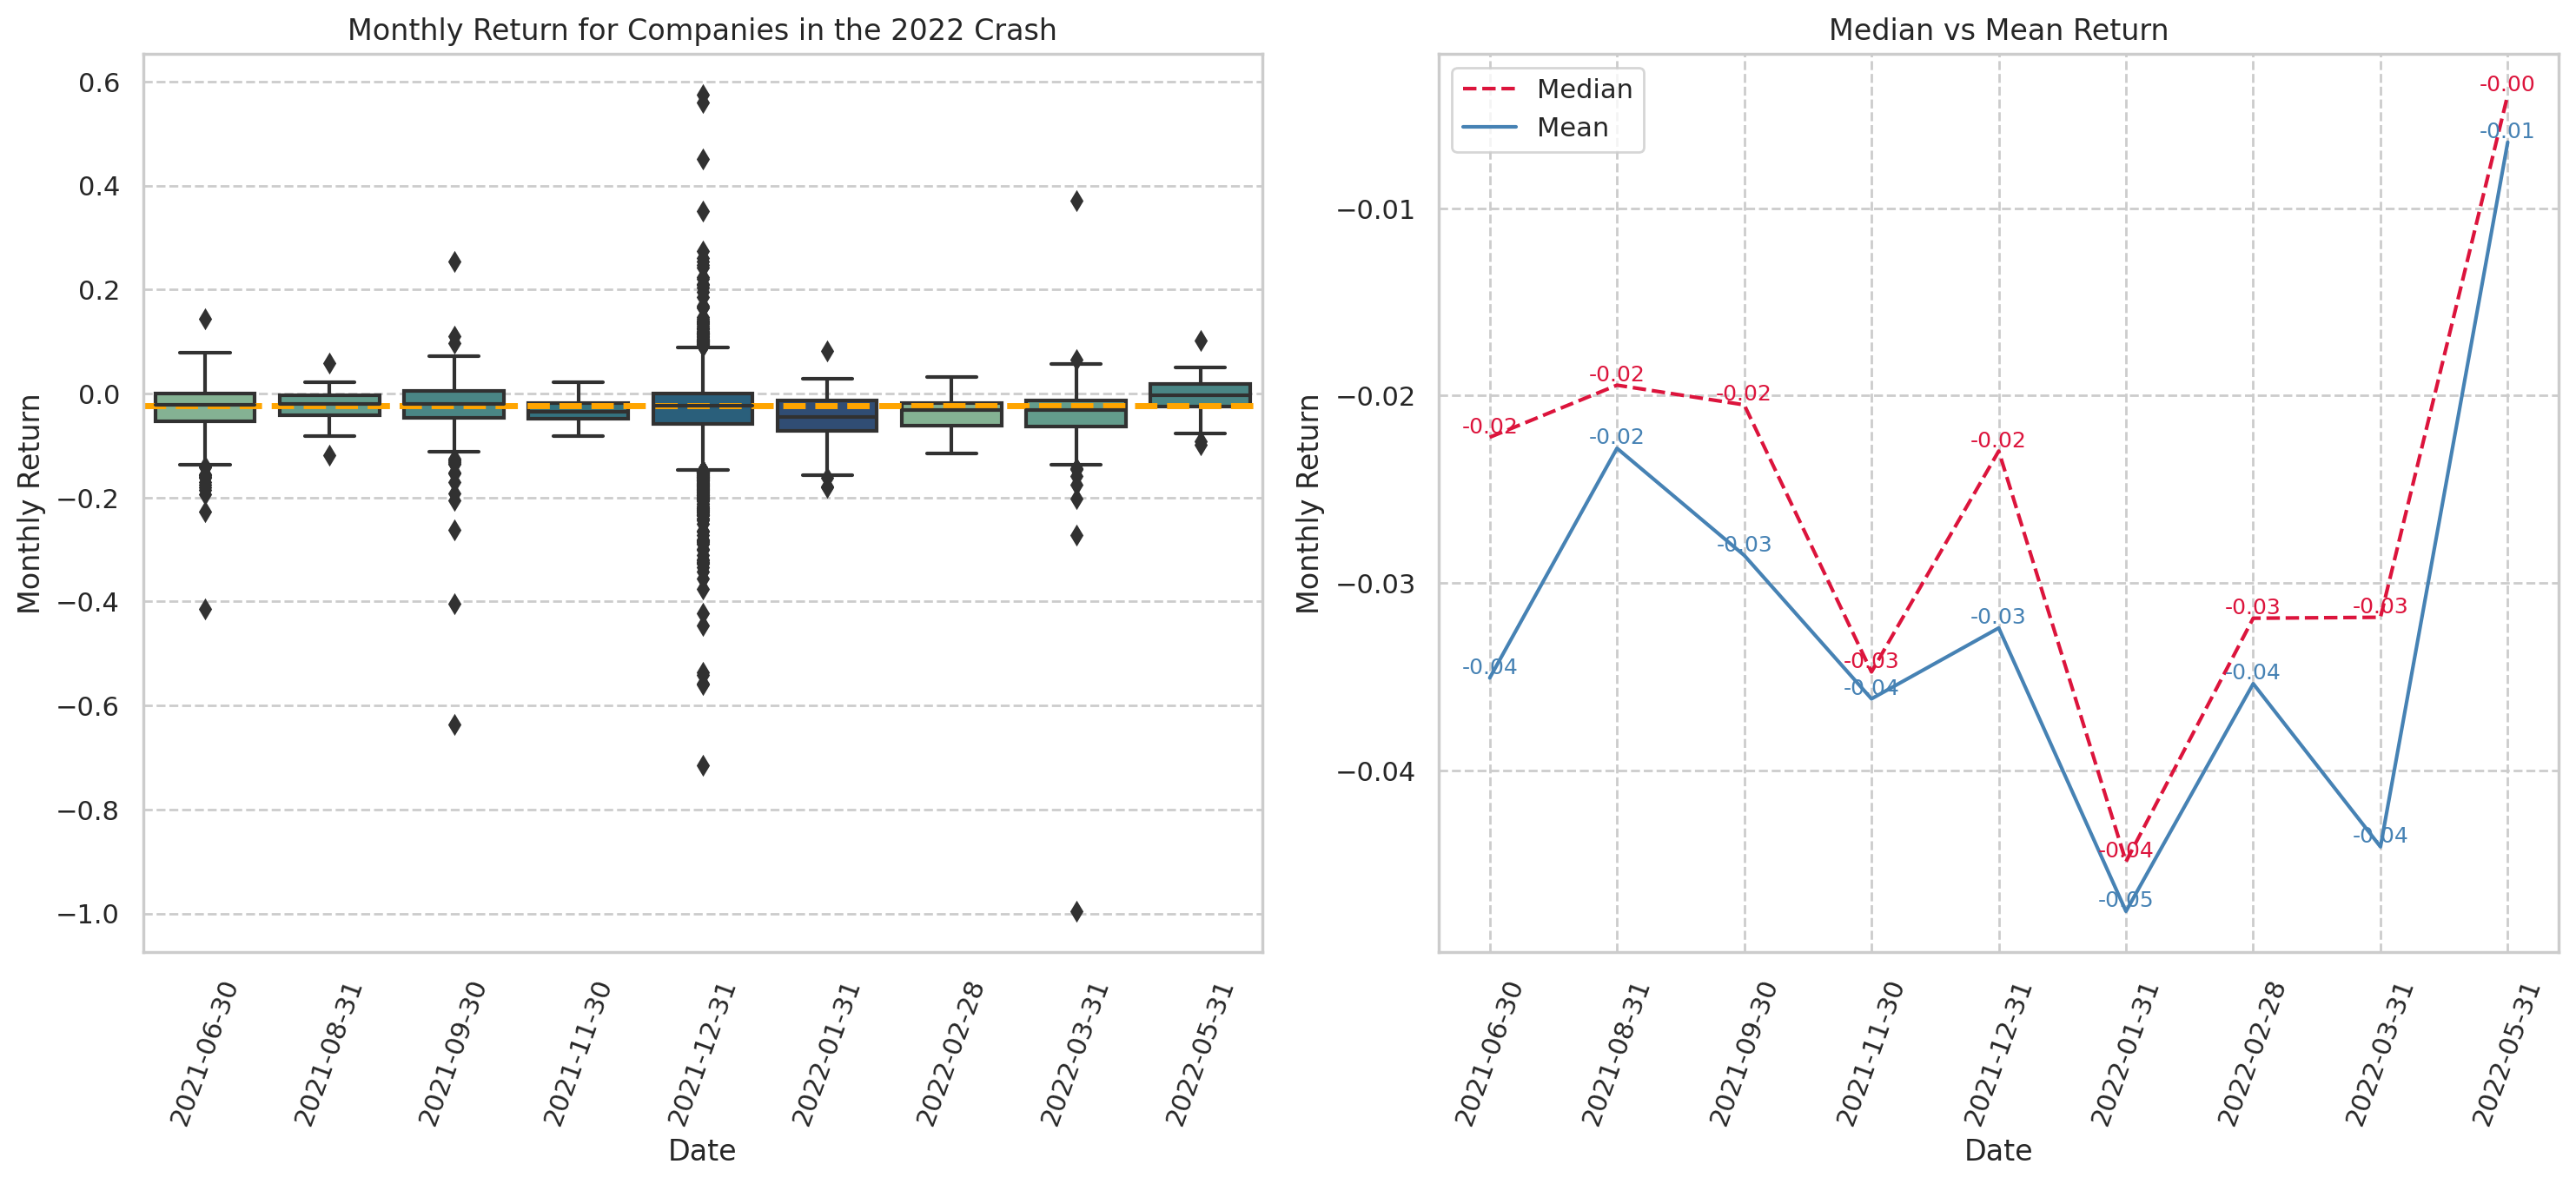

In [204]:
# Analyzing stock returns over the crash period
palette = sns.color_palette('crest')
merged_2022 = merged_2022.sort_values('datadate')
median_return = merged_2022['RET'].median()
mean_return = merged_2022['RET'].mean()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# Boxplot on avg RET distribution
sns.boxplot(x='datadate', y='RET', data=merged_2022, palette=palette, ax=ax1)
ax1.axhline(y=median_return, color='orange', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Return')
ax1.set_xticklabels(labels=merged_2022['datadate'].unique(), rotation=70)
ax1.set_title('Monthly Return for Companies in the 2022 Crash')
# Line plot on avg vs median RET comparison
x = merged_2022['datadate'].unique()
y_median = merged_2022.groupby('datadate')['RET'].median().values
y_mean = merged_2022.groupby('datadate')['RET'].mean().values
ax2.plot(x, y_median, color='crimson', linestyle='--', label='Median')
ax2.plot(x, y_mean, color='steelblue', linestyle='-', label='Mean')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_xticklabels(labels=x, rotation=70)
ax2.set_title('Median vs Mean Return')
ax2.legend()
for i, (xi, yi) in enumerate(zip(x, y_median)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='crimson')
for i, (xi, yi) in enumerate(zip(x, y_mean)):
    ax2.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9, color='steelblue')
fig.tight_layout()
plt.show()

- Monthly average stock return $RET_t$ follows a very different pattern compared to all previous periods, with a much wider return spectrum $[-0.8, 0.6]$. **This may be caused by the ridiculous amounts of overvaluation of tech companies during the "easy-money" period, and backfired when the Fed started lifting interest rates up to curb inflation.** $12/31/2021$ is particularly volatile compared to the other 4 crashes, with higher concentration of companies at both ends of the return spectrum. The overall median return for this period is slightly below 0%.

#### **Regression $(RET_t)$ Analysis on Various Features**

In [205]:
# Regression 1 - Ratio Analysis
import statsmodels.api as sm
ratio = final_2022[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
X = ratio.fillna(0)
X = sm.add_constant(X)
y = final_2022['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     85.55
Date:                Sat, 06 May 2023   Prob (F-statistic):          3.65e-102
Time:                        03:30:20   Log-Likelihood:                 6328.0
No. Observations:                4781   AIC:                        -1.264e+04
Df Residuals:                    4774   BIC:                        -1.260e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0699      0.005    -15.521      0.000      -0.079      -0.061
at             0.0014      0.001      1.332      0.183      -0.001       0.003
ROA            0.0014      0.001      1.926      0.054   -2.49e-05       0.003
ROE           -0.0062      0.001     -5.997      0.000      -0.008      -0.004
asset_turn     0.0012      0.001      1.222      0.222      -0.001       0.003
net_margin    -0.0013      0.001     -1.070      0.285      -0.004       0.001
debt_asset     0.0034      0.001      5.425      0.000       0.002       0.005
==============================================================================
Omnibus:                     1760.006   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102773.850
Skew:                          -0.946   Prob(JB):                         0.00
Kurtosis:                      25.635   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
# Regression 2 - Industry-Fixed Effect
import statsmodels.api as sm
sector = final_2022.iloc[:, 19:29] #drop gsector_10 as the base comparison
X = sector.fillna(0)
X = sm.add_constant(X)
y = final_2022['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     49.11
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.37e-94
Time:                        03:30:20   Log-Likelihood:                 6318.1
No. Observations:                4781   AIC:                        -1.261e+04
Df Residuals:                    4770   BIC:                        -1.254e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0329      0.004      8.181      0.000       0.025       0.041
gsector_15.0    -0.0469      0.006     -7.998      0.000      -0.058      -0.035
gsector_20.0    -0.0640      0.005    -13.402      0.000      -0.073      -0.055
gsector_25.0    -0.0800      0.005    -16.398      0.000      -0.090      -0.070
gsector_30.0    -0.0685      0.006    -11.009      0.000      -0.081      -0.056
gsector_35.0    -0.0799      0.005    -17.515      0.000      -0.089      -0.071
gsector_40.0    -0.0537      0.005    -11.642      0.000      -0.063      -0.045
gsector_45.0    -0.0825      0.005    -17.280      0.000      -0.092      -0.073
gsector_50.0    -0.0894      0.006    -15.646      0.000      -0.101      -0.078
gsector_55.0    -0.0314      0.008     -4.049      0.000      -0.047      -0.016
gsector_60.0    -0.0603      0.006    -10.178      0.000      -0.072      -0.049
==============================================================================
Omnibus:                     2265.014   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119769.323
Skew:                          -1.492   Prob(JB):                         0.00
Kurtosis:                      27.338   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [207]:
# Regression 3 - Combined Regression
import statsmodels.api as sm
sector = final_2022.iloc[:, 19:29] #drop gsector_10 as the base comparison
ratio = final_2022[['at', 'ROA', 'ROE', 'asset_turn', 'net_margin', 'debt_asset']]
risk = final_2022[['smb', 'hml', 'mktrf']]
X = pd.concat([sector, ratio, risk], axis=1).fillna(0)
X = sm.add_constant(X)
y = final_2022['RET']
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     47.46
Date:                Sat, 06 May 2023   Prob (F-statistic):          3.47e-163
Time:                        03:30:20   Log-Likelihood:                 6498.5
No. Observations:                4781   AIC:                        -1.296e+04
Df Residuals:                    4761   BIC:                        -1.283e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0056      0.006     -0.903      0.366      -0.018       0.007
gsector_15.0    -0.0501      0.006     -8.793      0.000      -0.061      -0.039
gsector_20.0    -0.0634      0.005    -13.567      0.000      -0.073      -0.054
gsector_25.0    -0.0769      0.005    -15.879      0.000      -0.086      -0.067
gsector_30.0    -0.0690      0.006    -11.315      0.000      -0.081      -0.057
gsector_35.0    -0.0616      0.005    -13.457      0.000      -0.071      -0.053
gsector_40.0    -0.0607      0.005    -12.835      0.000      -0.070      -0.051
gsector_45.0    -0.0710      0.005    -15.016      0.000      -0.080      -0.062
gsector_50.0    -0.0842      0.006    -15.231      0.000      -0.095      -0.073
gsector_55.0    -0.0426      0.008     -5.646      0.000      -0.057      -0.028
gsector_60.0    -0.0619      0.006    -10.714      0.000      -0.073      -0.051
at               0.0015      0.001      1.422      0.155      -0.001       0.004
ROA              0.0013      0.001      1.816      0.069      -0.000       0.003
ROE             -0.0045      0.001     -4.093      0.000      -0.007      -0.002
asset_turn       0.0016      0.001      1.558      0.119      -0.000       0.004
net_margin      -0.0029      0.001     -2.467      0.014      -0.005      -0.001
debt_asset       0.0023      0.001      3.753      0.000       0.001       0.004
smb              0.2828      0.132      2.141      0.032       0.024       0.542
hml              0.0675      0.057      1.187      0.235      -0.044       0.179
mktrf            0.0374      0.054      0.692      0.489      -0.069       0.143
==============================================================================
Omnibus:                     1913.871   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           134343.970
Skew:                          -1.051   Prob(JB):                         0.00
Kurtosis:                      28.884   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression Comparison Results**: Regressing on characteristics alone has an $Adj R^2$ of 9.7%, and industry effects have an $Adj R^2$ of 9.1%. Regression based on industry yielded lower performance compared to the first model with lower $Adj R^2$. Significant variables include all financial features except Asset Turnover, and all industry sectors are shown as significant too. 

**Regression #3 Interpretation (Industry + Risk Exposure + Ratios):**

\begin{align*}
RET_t &= \alpha_0 + \beta_1(R_M-R_f) + \beta_2SMB + \beta_3HML + \gamma_1ROA + \gamma_2ROE \\
&\quad + \gamma_3Asset\ Turnover + \gamma_4Net\ Margin + \gamma_5Debt\ Asset + \gamma_6\log(Asset) \\
&\quad + \alpha_igsector_{15-60} + \epsilon_i
\end{align*}

1. **The 2022 regression model generated many statistically significant variables, with an $Adj. R^2$ of 15.8%, similar to the 2020 model's performance.** 
1. **Intercept**: On average, during 2022, companies in the **gsector10 industry (Energy)** generated a monthly return of -3.36%, assuming all other variables = 0. We have 4781 observations in total, each representing a ticker symbol in the `final_2022` dataset. 
1. **Industry Coefficients**: All industry variables are statistically significant. Industries that differ the most from the baseline Energy benchmark are Communication Services, Information Technology, and Consumer Discretionary. IT and communication are hit particularly hard since they borrowed large amounts of debt during 2020 and couldn't sustain the high leverage with the amount of cash they were generating in 2022. 
1. **Financial Characteristics**: All financial ratios except Asset Turnover are significant. A 1% increase in Assets indicates a 2.64% increase in $RET$, so firms that are larger in asset size performed better in 2022 on average. A 1% increase in ROA indicates a 0.17% increase in $RET$, meaning that more profitable companies are rewarded with higher $RET$. 
1. **Fama-French 3 Factors**: Interestingly, 2022 is the only period to see `SMB` having significant results compared to all other crashes. This means if a company has a smaller market capitalization, their average $RET$ will improve by 27.26% on average, holding others constant. This may due to the fact of the SPAC (special purpose acquisition company) bubble in late 2021 which happened during the ultra-low interest environment, and fueled investors' enthusiasm in investing in relatively underfollowed small-cap companies. However, the reason why $SMB$ is significant in 2022 remains undetermined without more data. 
---
